In [1]:
import pandas as pd

# Import TPM

In [2]:
tpm_filepath_ct = '4_epr_outputs/ct_outputs/epkm_4_tpms/tpm.exons.tsv'

tpm_filepath_ai = '4_epr_outputs/ai_outputs/epkm_4_tpms/tpm.exons.tsv'

tpm_filepath_ct_stranded = '4_epr_outputs/stranded_ct_outputs/epkm_4_tpms/tpm.exons.tsv'

tpm_filepath_ai_stranded = '4_epr_outputs/stranded_ai_outputs/epkm_4_tpms/tpm.exons.tsv'

In [3]:
def clean_col(c):
    # Because Torin and Untreated samples were switched, switch the labels here
    if '/' in c:
        c = c.split("/")[-1]
        
    if 'APOBE_' in c:
        c = c.replace('APOBE_', 'APOBEC1_')
    
    if 'Torin' in c:
        c = c.replace('Torin', 'Untreated')
    elif 'Untreated' in c:
        c = c.replace('Untreated', 'Torin')

    
    if 'Aligned' in c:
        return c.split('Aligned')[0]
    else:
        return 'Bad'


def clean_columns(df):
    print('Cleaning metric columns...')
    df.columns = [clean_col(c) for c in df.columns]
    df = df.drop('Bad', axis=1)
    return df 

def load_metrics(filepath):
    metric_df = pd.read_csv(filepath, sep='\t', index_col=0)
    metric_df = clean_columns(metric_df)
    metric_df = drop_zero_genes(metric_df)
    return metric_df

def drop_zero_genes(metric_df):
    print('Dropping genes with zeros across all samples')
    print("\tBefore: {}".format(len(metric_df)))
    metric_df = metric_df.loc[metric_df.sum(axis=1) > 0]
    print("\tAfter: {}".format(len(metric_df)))
    return metric_df
    
def convert_to_gene_symbols(metric_df):
    conversion = pd.read_csv('/projects/ps-yeolab3/ekofman/ReferenceData/enst_ensg_genename.txt', sep='\t')
    conversion.index = conversion['Gene stable ID']
    conversion = conversion.drop_duplicates(['Gene stable ID'])
    len(conversion)
    
    # Convert to gene symbols
    metric_df = metric_df.join(conversion).drop_duplicates()
    metric_df.index = metric_df['Gene name']

    metric_df = metric_df.drop([
        'Gene stable ID',
        'Gene stable ID version',
        'Transcript stable ID',
        'Transcript stable ID version',
        'Gene name'
    ], axis=1)
    
    return metric_df


def filter_metric_by_tpm(metric_df, tpm_df, thresh=0.5):
    # Only keep where all tpms are above 0.5 for all samples
    tpm_df = tpm_df.loc[(tpm_df > thresh).T.sum() == len(tpm_df.columns)]
    
    print("Filtering metric by TPM...")
    print("\tBefore: {}".format(len(metric_df)))
    metric_df = metric_df[metric_df.index.isin(tpm_df.index)]
    print("\tAfter: {}".format(len(metric_df)))
    return metric_df





In [4]:
metric = 'epr'

filepath_cds_ct = '4_epr_outputs/ct_outputs/epkm_6_epkms_merged/{}.CDS.merged.tsv'.format(metric)
filepath_cds_ai = '4_epr_outputs/ai_outputs/epkm_6_epkms_merged/{}.CDS.merged.tsv'.format(metric)
filepath_3_ct = '4_epr_outputs/ct_outputs/epkm_6_epkms_merged/{}.three_prime_utr.merged.tsv'.format(metric)
filepath_3_ai = '4_epr_outputs/ai_outputs/epkm_6_epkms_merged/{}.three_prime_utr.merged.tsv'.format(metric)

filepath_ct = '4_epr_outputs/ct_outputs/epkm_6_epkms_merged/{}.exons.merged.tsv'.format(metric)
filepath_ai = '4_epr_outputs/ai_outputs/epkm_6_epkms_merged/{}.exons.merged.tsv'.format(metric)
filepath_ct_stranded = '4_epr_outputs/stranded_ct_outputs/epkm_6_epkms_merged/{}.exons.merged.tsv'.format(metric)
filepath_ai_stranded = '4_epr_outputs/stranded_ai_outputs/epkm_6_epkms_merged/{}.exons.merged.tsv'.format(metric)

print('CT')
tpm_df_ct = load_metrics(tpm_filepath_ct)
metric_df_ct = load_metrics(filepath_ct)
print('CDS')
metric_df_cds_ct = load_metrics(filepath_cds_ct)
print('3')
metric_df_3_ct = load_metrics(filepath_3_ct)

metric_df_ct = filter_metric_by_tpm(metric_df_ct, tpm_df_ct, thresh=0.5)
metric_df_ct = convert_to_gene_symbols(metric_df_ct)
print('\tCDS')
metric_df_cds_ct = filter_metric_by_tpm(metric_df_cds_ct, tpm_df_ct, thresh=0.5)
#metric_df_cds_ct = convert_to_gene_symbols(metric_df_cds_ct)
print('\t3utr')
metric_df_3_ct = filter_metric_by_tpm(metric_df_3_ct, tpm_df_ct, thresh=0.5)
#metric_df_3_ct = convert_to_gene_symbols(metric_df_cds_ct)

print('CT stranded')
tpm_df_ct_stranded = load_metrics(tpm_filepath_ct_stranded)
metric_df_ct_stranded = load_metrics(filepath_ct_stranded)
metric_df_ct_stranded = filter_metric_by_tpm(metric_df_ct_stranded, tpm_df_ct_stranded, thresh=0.5)
metric_df_ct_stranded = convert_to_gene_symbols(metric_df_ct_stranded)

print('AI')
tpm_df_ai = load_metrics(tpm_filepath_ai)
metric_df_ai = load_metrics(filepath_ai)
print('\tCDS')
metric_df_cds_ai = load_metrics(filepath_cds_ai)
print('\t3')
metric_df_3_ai = load_metrics(filepath_3_ai)

metric_df_ai = filter_metric_by_tpm(metric_df_ai, tpm_df_ai, thresh=0.5)
metric_df_ai = convert_to_gene_symbols(metric_df_ai)
print('\tCDS')
metric_df_cds_ai = filter_metric_by_tpm(metric_df_cds_ai, tpm_df_ai, thresh=0.5)
#metric_df_cds_ai = convert_to_gene_symbols(metric_df_cds_ai)
print("\t3utr")
metric_df_3_ai = filter_metric_by_tpm(metric_df_3_ai, tpm_df_ai, thresh=0.5)
#metric_df_3_ai = convert_to_gene_symbols(metric_df_3_ai)

print('AI stranded')
tpm_df_ai_stranded = load_metrics(tpm_filepath_ai_stranded)
metric_df_ai_stranded = load_metrics(filepath_ai_stranded)
metric_df_ai_stranded = filter_metric_by_tpm(metric_df_ai_stranded, tpm_df_ai_stranded, thresh=0.5)
metric_df_ai_stranded = convert_to_gene_symbols(metric_df_ai_stranded)

len(metric_df_ct), len(metric_df_ai), len(metric_df_ct_stranded), len(metric_df_ai_stranded)


CT
Cleaning metric columns...
Dropping genes with zeros across all samples
	Before: 33538
	After: 29773
Cleaning metric columns...
Dropping genes with zeros across all samples
	Before: 33538
	After: 18773
CDS
Cleaning metric columns...
Dropping genes with zeros across all samples
	Before: 20320
	After: 13730
3
Cleaning metric columns...
Dropping genes with zeros across all samples
	Before: 19462
	After: 13173
Filtering metric by TPM...
	Before: 18773
	After: 4292
	CDS
Filtering metric by TPM...
	Before: 13730
	After: 3745
	3utr
Filtering metric by TPM...
	Before: 13173
	After: 3707
CT stranded
Cleaning metric columns...
Dropping genes with zeros across all samples
	Before: 33538
	After: 29792
Cleaning metric columns...
Dropping genes with zeros across all samples
	Before: 33538
	After: 18590
Filtering metric by TPM...
	Before: 18590
	After: 4406
AI
Cleaning metric columns...
Dropping genes with zeros across all samples
	Before: 33538
	After: 30617
Cleaning metric columns...
Dropping ge

(4292, 4237, 4406, 4258)

# Compare 3' to CDS

In [5]:
# Only first strand
metric_df_cds_ai_1 = metric_df_cds_ai[[c for c in metric_df_cds_ai.columns if '_1_' in c]]
metric_df_3_ai_1 = metric_df_3_ai[[c for c in metric_df_3_ai.columns if '_1_' in c]]
metric_df_cds_ct_1 = metric_df_cds_ct[[c for c in metric_df_cds_ct.columns if '_1_' in c]]
metric_df_3_ct_1 = metric_df_3_ct[[c for c in metric_df_3_ct.columns if '_1_' in c]]


metric_df_3_ai_1 = metric_df_3_ai_1[~metric_df_3_ai_1.index.isna()].drop_duplicates()
metric_df_cds_ai_1 = metric_df_cds_ai_1[~metric_df_cds_ai_1.index.isna()].drop_duplicates()
metric_df_3_ct_1 = metric_df_3_ct_1[~metric_df_3_ct_1.index.isna()].drop_duplicates()
metric_df_cds_ct_1 = metric_df_cds_ct_1[~metric_df_cds_ct_1.index.isna()].drop_duplicates()

In [6]:

# Transpose
metric_df_3_ai_t = metric_df_3_ai_1.T
metric_df_cds_ai_t = metric_df_cds_ai_1.T
metric_df_3_ct_t = metric_df_3_ct_1.T
metric_df_cds_ct_t = metric_df_cds_ct_1.T

# Make sure to only keep genes for which we have info for both 3' and CDS
metric_df_3_ai_t = metric_df_3_ai_t[[c for c in metric_df_3_ai_t if c in metric_df_cds_ai_t.columns]]
metric_df_cds_ai_t = metric_df_cds_ai_t[[c for c in metric_df_cds_ai_t if c in metric_df_cds_ai_t.columns]]
metric_df_3_ct_t = metric_df_3_ct_t[[c for c in metric_df_3_ct_t if c in metric_df_cds_ct_t.columns]]
metric_df_cds_ct_t = metric_df_cds_ct_t[[c for c in metric_df_cds_ct_t if c in metric_df_cds_ct_t.columns]]

# Join 3' and CDS EPR info
metric_cds_3_ai_joined = metric_df_3_ai_t.join(metric_df_cds_ai_t, rsuffix='_CDS', lsuffix='_3utr', how='inner')
metric_cds_3_ct_joined = metric_df_3_ct_t.join(metric_df_cds_ct_t, rsuffix='_CDS', lsuffix='_3utr', how='inner')
metric_cds_3_ai_joined = metric_cds_3_ai_joined[sorted(metric_cds_3_ai_joined.columns)]
metric_cds_3_ct_joined = metric_cds_3_ct_joined[sorted(metric_cds_3_ct_joined.columns)]

In [7]:
import numpy as np

# calculate ratio for each gene shared by both...
indiv_genes_ai = sorted(set([c.split('_')[0] for c in metric_df_3_ai_t.columns]))
indiv_genes_ct = sorted(set([c.split('_')[0] for c in metric_df_3_ct_t.columns]))

for g in indiv_genes_ai:
    metric_cds_3_ai_joined[g] = np.log(metric_cds_3_ai_joined['{}_CDS'.format(g)]+1) - np.log(metric_cds_3_ai_joined['{}_3utr'.format(g)] + 1)
for g in indiv_genes_ct:
    metric_cds_3_ct_joined[g] = np.log(metric_cds_3_ct_joined['{}_CDS'.format(g)]+1) - np.log(metric_cds_3_ct_joined['{}_3utr'.format(g)] + 1)

In [8]:
metric_cds_3_ai_joined_ratio = metric_cds_3_ai_joined[
    [c for c in metric_cds_3_ai_joined.columns if 'CDS' not in c and '3utr' not in c]]
metric_cds_3_ct_joined_ratio = metric_cds_3_ct_joined[
    [c for c in metric_cds_3_ct_joined.columns if 'CDS' not in c and '3utr' not in c]]

In [9]:
metric_cds_3_ai_joined_ratio = metric_cds_3_ai_joined_ratio.loc[[i for i in metric_cds_3_ai_joined_ratio.index if 'alone' not in i]]
metric_cds_3_ct_joined_ratio = metric_cds_3_ct_joined_ratio.loc[[i for i in metric_cds_3_ct_joined_ratio.index if 'alone' not in i]]

In [10]:
metric_cds_3_ai_joined_ratio = metric_cds_3_ai_joined_ratio.T
metric_cds_3_ct_joined_ratio = metric_cds_3_ct_joined_ratio.T

In [11]:
# recolumn

def new_col(c):
    for r in ['R1', 'R2', 'R3']:
        if r in c:
            c = c.replace('{}_1_'.format(r), '')
            c = '{}_{}'.format(c, r)
            return c
    
metric_cds_3_ct_joined_ratio.columns = [new_col(c) for c in metric_cds_3_ct_joined_ratio.columns]
metric_cds_3_ai_joined_ratio.columns = [new_col(c) for c in metric_cds_3_ai_joined_ratio.columns]

In [12]:
metric_cds_3_ct_joined_ratio = metric_cds_3_ct_joined_ratio[sorted(metric_cds_3_ct_joined_ratio.columns)]
metric_cds_3_ai_joined_ratio = metric_cds_3_ai_joined_ratio[sorted(metric_cds_3_ai_joined_ratio.columns)]

In [13]:
metric_cds_3_all_joined_ratio = metric_cds_3_ct_joined_ratio.join(metric_cds_3_ai_joined_ratio, how='inner', rsuffix='_AI', lsuffix='_CT')

<AxesSubplot:>

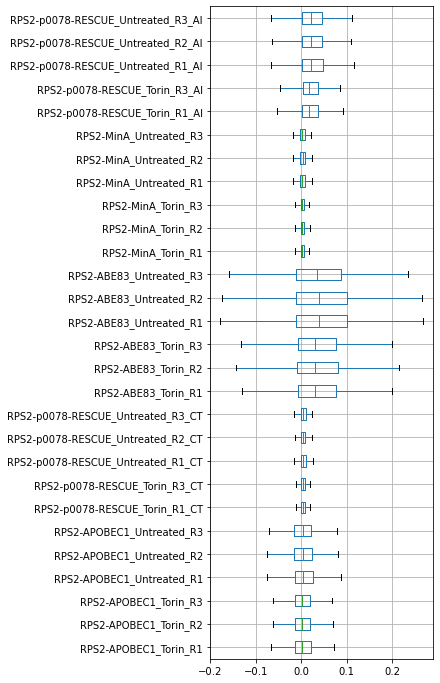

In [24]:
metric_cds_3_all_joined_ratio.boxplot(vert=False, figsize=(4, 12), showfliers=False)

In [25]:
from collections import defaultdict

# combine replicates
overall_label_to_columns = defaultdict(lambda:[])

for c in metric_cds_3_all_joined_ratio.columns:
    for r in ['R1', 'R2', 'R3']:
        if r in c:
            overall_label = c.replace('_{}'.format(r), '')
    overall_label_to_columns[overall_label].append(c)

for k, vals in overall_label_to_columns.items():
    avg = metric_cds_3_all_joined_ratio[vals].mean(axis=1)
    metric_cds_3_all_joined_ratio[k] = avg

metric_cds_3_all_joined_ratio_reps_avgd = metric_cds_3_all_joined_ratio[
    [c for c in metric_cds_3_all_joined_ratio if 'R1' not in c and 'R2' not in c and 'R3' not in c]]

In [26]:
metric_cds_3_all_joined_ratio_reps_avgd = metric_cds_3_all_joined_ratio_reps_avgd[[c for c in metric_cds_3_all_joined_ratio_reps_avgd.columns if not ('78' in c and 'CT' in c)]]

In [27]:
new_cols = []
for c in metric_cds_3_all_joined_ratio_reps_avgd.columns:
    if '78' in c:
        new_cols.append(c.replace('_AI', ''))
    else:
        new_cols.append(c)
metric_cds_3_all_joined_ratio_reps_avgd.columns = new_cols

In [28]:
# TOP genes

top_genes = 'PABPC1,EIF4B,EIF3A,EIF3E,NAP1L1,VIM,EIF3F,EEF1A1,EEF1B2,EEF1G,EEF1D,EEF2,RACK1,NPM1,TPT1,RPL22,RPL3,RPSA,RPS2,RPS3,RPS3A,RPS4X,RPS4Y1,RPS5,RPS6,RPS7,RPS8,RPS9,RPS10,RPS11,RPS12,RPS13,RPS14,RPS15,RPS15A,RPS16,RPS17,RPS18,RPS19,RPS20,RPS21,RPS23,RPS24,RPS25,RPS26,RPS27,RPS27A,RPS28,RPS29,FAU,RPLP0,RPLP1,RPLP2,RPL3,RPL4,RPL5,RPL6,RPL7,RPL7A,RPL8,RPL9,RPL10,RPL11,RPL10A,RPL12,RPL13,RPL13A,RPL14,RPL15,RPL17,RPL18,RPL18A,RPL19,RPL21,RPL22,RPL23,RPL23A,RPL24,RPL26,RPL27,RPL27A,RPL30,RPL31,RPL32,RPL34,RPL35,RPL36,RPL36A,RPL37,RPL39,UBA52,RPL41'
top_genes_list = top_genes.split(',')

conversion = pd.read_csv('/projects/ps-yeolab3/ekofman/ReferenceData/enst_ensg_genename.txt', sep='\t')
conversion.index = conversion['Gene stable ID']
conversion = conversion.drop_duplicates(['Gene stable ID'])
len(conversion)

top_genes_list_ensg = list(conversion[conversion['Gene name'].isin(top_genes_list)].index)


76


(-0.25, 0.6)

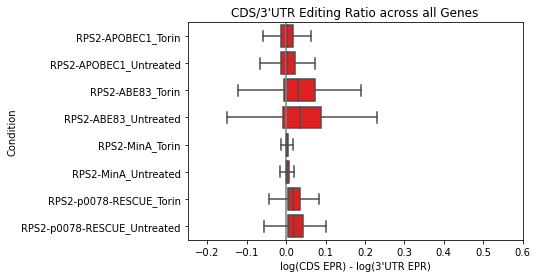

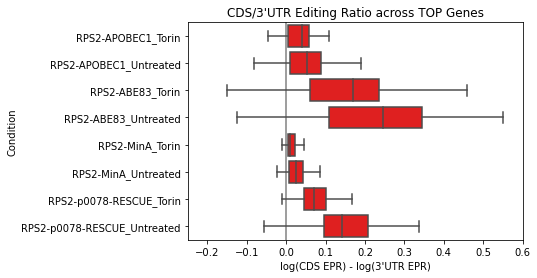

In [29]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure()
plt.axvline(0, color='gray')
sns.boxplot(data=metric_cds_3_all_joined_ratio_reps_avgd,
            orient='h', showfliers=False, color='r')
plt.xlabel("log(CDS EPR) - log(3'UTR EPR)")
plt.ylabel("Condition")
plt.title("CDS/3'UTR Editing Ratio across all Genes")
plt.xlim(-.25, .6)

metric_cds_3_all_joined_ratio_reps_avgd_TOP = metric_cds_3_all_joined_ratio_reps_avgd[metric_cds_3_all_joined_ratio_reps_avgd.index.isin(top_genes_list_ensg)]
#plt.savefig('images/svgs/top_genes_reductions/cds_3utr_epr_ratio_across_all_genes.svg'.format(label), bbox_inches='tight')

    
print(len(metric_cds_3_all_joined_ratio_reps_avgd_TOP))

plt.figure()
plt.axvline(0, color='gray')
sns.boxplot(data=metric_cds_3_all_joined_ratio_reps_avgd_TOP,
            orient='h', showfliers=False, color='r')
plt.xlabel("log(CDS EPR) - log(3'UTR EPR)")
plt.ylabel("Condition")
plt.title("CDS/3'UTR Editing Ratio across TOP Genes")
plt.xlim(-.25, .6)
#plt.savefig('images/svgs/top_genes_reductions/cds_3utr_epr_ratio_across_TOP_genes.svg'.format(label), bbox_inches='tight')


Torin1 induction leads to a decrease in CDS editing rate compared to 3'UTR editing rate across all enzymes. 

## cds and 3 values

In [30]:
metric_cds_3_ai_joined = metric_cds_3_ai_joined.T
metric_cds_3_ct_joined = metric_cds_3_ct_joined.T

metric_cds_3_ai_joined.columns = [new_col(c) for c in metric_cds_3_ai_joined.columns]
metric_cds_3_ct_joined.columns = [new_col(c) for c in metric_cds_3_ct_joined.columns]

### from this paper: https://www.nature.com/articles/s41594-022-00819-2#Fig8
* "...we examined the interaction of Torin 1-induced changes in translation with uORF frequency and CDS length, the two most important mRNA features affecting translational efficiency under mTOR-active conditions"
* "... increased translational efficiency of mRNAs with a CDS of close to 1 kb was not observed upon mTOR inhibition .... Rather, there was a progressive increase in mean ribosome load with increasing CDS length, as might be expected if CDS length was not affecting translational initiation. "
* CDS length is strong predictor of mean ribosome load (MRL) in mTOR-active condition
* "Note that an association of [total] mRNA length with mTOR sensitivity was also observed but was slightly weaker"

In [31]:
# Load CDS and 3'utr lengths

lengths_3 = pd.read_csv('4_epr_outputs/ai_outputs/epkm_0_feature_counts/three_prime_utr_counts.txt',
            comment='#', sep='\t')[['Geneid', 'Length']]
lengths_3.index = lengths_3.Geneid
lengths_3 = lengths_3.drop('Geneid', axis=1)
lengths_cds = pd.read_csv('4_epr_outputs/ai_outputs/epkm_0_feature_counts/CDS_counts.txt', 
                          comment='#', sep='\t')[['Geneid', 'Length']]
lengths_cds.index = lengths_cds.Geneid
lengths_cds = lengths_cds.drop('Geneid', axis=1)
gene_lengths = lengths_3.join(lengths_cds, rsuffix='_CDS', lsuffix='_3utr')

def get_length(i):
    ensg = i.split('_')[0]
    length = gene_lengths.loc[ensg]['Length_{}'.format(i.split("_")[1])]
    return length

In [32]:
metric_cds_3_all_joined = metric_cds_3_ct_joined.join(metric_cds_3_ai_joined, rsuffix='_AI', how='inner')


In [33]:
metric_cds_3_all_joined = metric_cds_3_all_joined.loc[[i for i in metric_cds_3_all_joined.index if '3utr' in i or 'CDS' in i]]


In [34]:

metric_cds_3_all_joined = metric_cds_3_all_joined[[c for c in metric_cds_3_all_joined.columns \
                                                   if not ('78' in c and 'AI' not in c)]]



# Get presaved metrics

In [52]:
metric_cds_3_all_joined = pd.read_csv('processed_EPR_values/epr_cds_3_all_joined.tsv', sep='\t',
                                              index_col=0)

In [56]:
metric_cds_3_all_joined = metric_cds_3_all_joined[sorted([c for c in metric_cds_3_all_joined.columns])]

In [57]:
#metric_cds_3_all_joined.to_csv('processed_EPR_values/epr_cds_3_all_joined.tsv', sep='\t', index=True,
#                              header=True)

In [60]:
#metric_cds_3_all_joined_stranded = pd.read_csv('processed_EPR_values/epr_cds_3_all_joined_stranded.tsv', sep='\t',
#                                              index_col=0)
#col78 = metric_cds_3_all_joined_stranded[[c for c in metric_cds_3_all_joined_stranded.columns if c not in metric_cds_3_all_joined.columns]]

In [61]:
#metric_cds_3_all_joined = metric_cds_3_all_joined.join(col78)

In [62]:
metric_cds_3_all_joined = metric_cds_3_all_joined[sorted([c for c in metric_cds_3_all_joined])]

In [63]:
metric_cds_3_all_joined['length'] = [get_length(i) for i in metric_cds_3_all_joined.index]


In [64]:
metric_cds_3_all_joined = metric_cds_3_all_joined[(metric_cds_3_all_joined.length > 100) &
    (~metric_cds_3_all_joined.index.isin(metric_cds_3_all_joined.drop('length', axis=1).T.mean().sort_values().tail(10).index))]


In [65]:
metric_cds_all_joined = metric_cds_3_all_joined.loc[[i for i in metric_cds_3_all_joined.index if 'CDS' in i]][
    [c for c in metric_cds_3_all_joined.columns if 'alone' not in c and 'Torin' not in c]]

metric_3utr_all_joined = metric_cds_3_all_joined.loc[[i for i in metric_cds_3_all_joined.index if '3utr' in i]][
    [c for c in metric_cds_3_all_joined.columns if 'alone' not in c and 'Torin' not in c]]


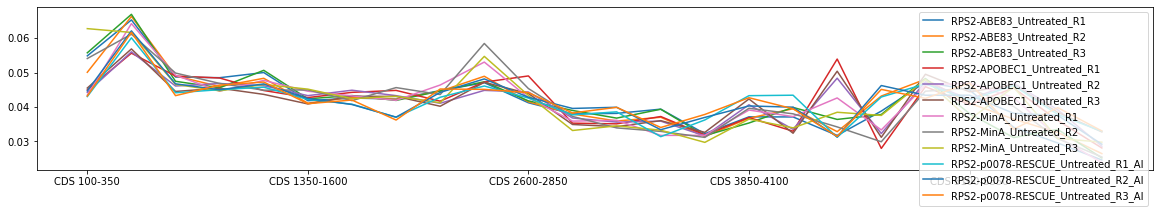

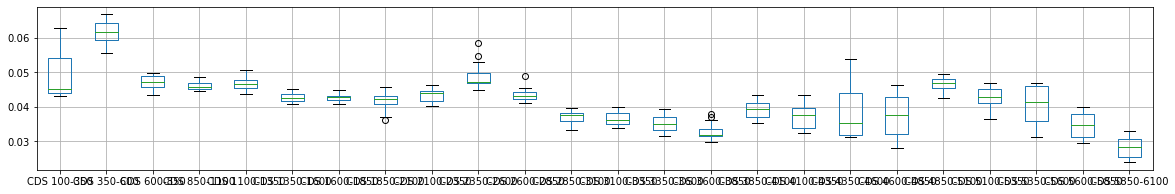

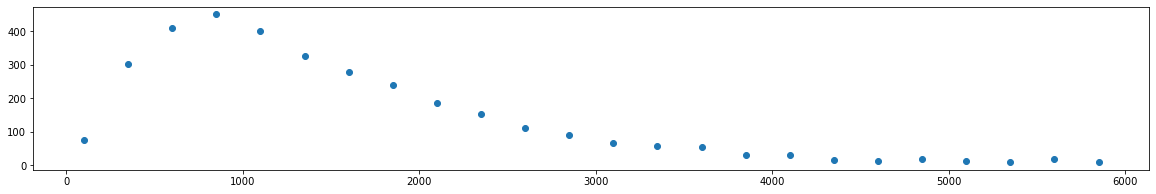

In [66]:
length_bounded_cds_values = []

num_genes = []
lower_bounds = range(100, 6000, 250)
for lower_bound in lower_bounds:
    upper_bound = lower_bound + 250
    rows_cds = metric_cds_all_joined[(metric_cds_all_joined.length > lower_bound) \
                                              & (metric_cds_all_joined.length < upper_bound)]
    
    #rows_cds = metric_3utr_all_joined.loc[metric_3utr_all_joined.index.isin(['{}_3utr'.format(i.split('_')[0]) for i in rows_cds.index])]

    
    num_genes.append(len(rows_cds))
    length_bounded_cds_values.append(pd.DataFrame(rows_cds.mean(),
                                              columns=['CDS {}-{}'.format(lower_bound,
                                                                      upper_bound)])                             
                                 
                                )
bounded_values_df = pd.concat(length_bounded_cds_values, axis=1)
bounded_values_df = bounded_values_df.drop('length')

bounded_normalized_values_df = (bounded_values_df.T/bounded_values_df.T.sum()).T

bounded_normalized_values_df.T.plot(figsize=(20, 3))

plt.figure(figsize=(20, 3))
bounded_normalized_values_df.boxplot()

plt.figure(figsize=(20, 3))
plt.scatter(lower_bounds, num_genes)

In [67]:
metric_cds_3_all_joined_TOP = metric_cds_3_all_joined.loc[[i for i in metric_cds_3_all_joined.index if i.split('_CDS')[0] in (top_genes_list_ensg) \
                             or i.split('_3utr')[0] in (top_genes_list_ensg)]]
metric_cds_3_all_joined_TOP = metric_cds_3_all_joined_TOP[[c for c in metric_cds_3_all_joined_TOP.columns]]


In [68]:
metric_cds_3_all_joined_TOP = metric_cds_3_all_joined_TOP[[c for c in metric_cds_3_all_joined_TOP.columns if 'alone' not in c]]

In [69]:
metric_cds_3_all_joined_TOP = metric_cds_3_all_joined_TOP[sorted(metric_cds_3_all_joined_TOP.columns)]

In [70]:
metric_cds_3_all_joined_TOP = metric_cds_3_all_joined_TOP[[c for c in metric_cds_3_all_joined_TOP.columns if 'alone' not in c]]

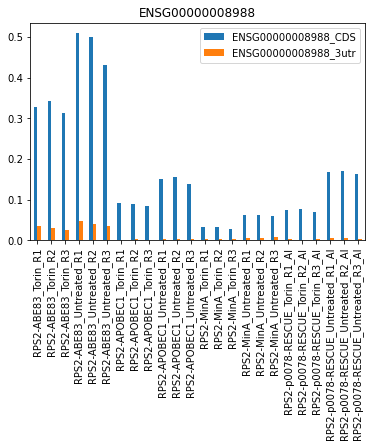

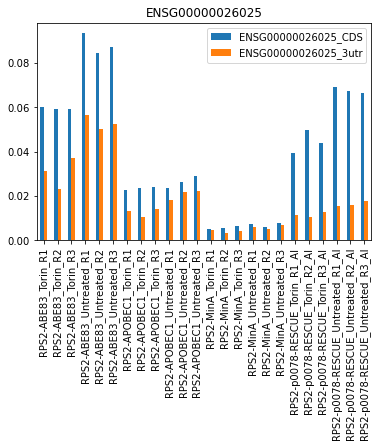

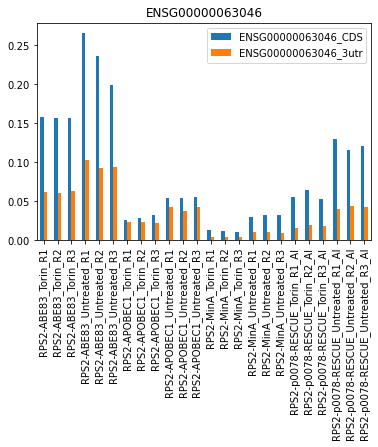

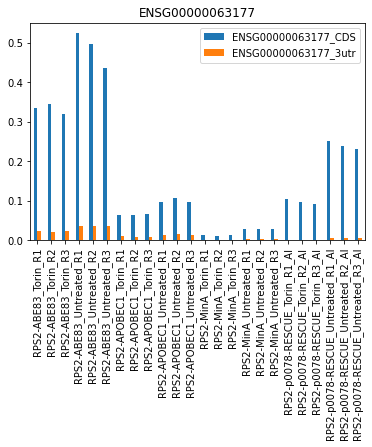

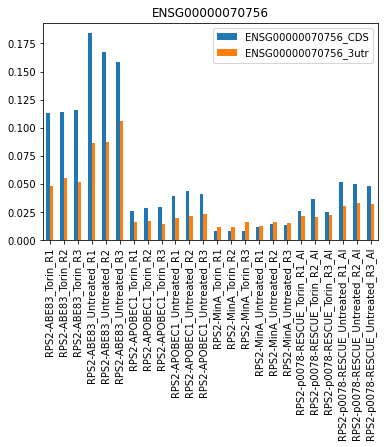

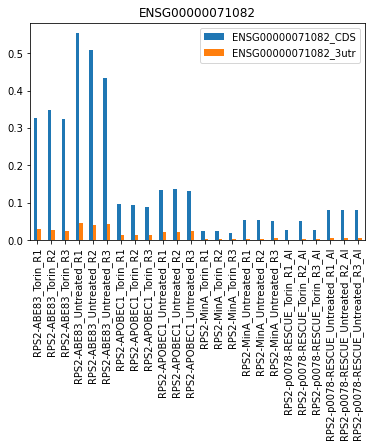

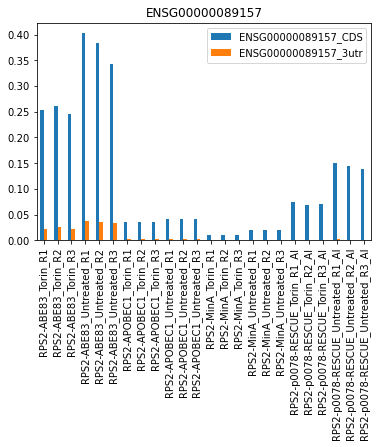

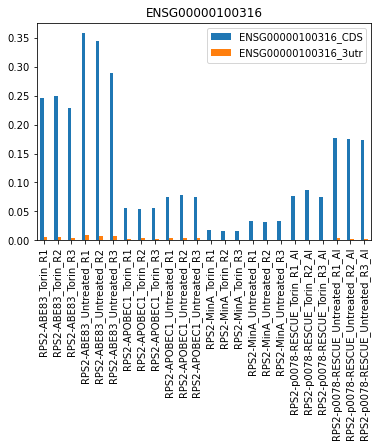

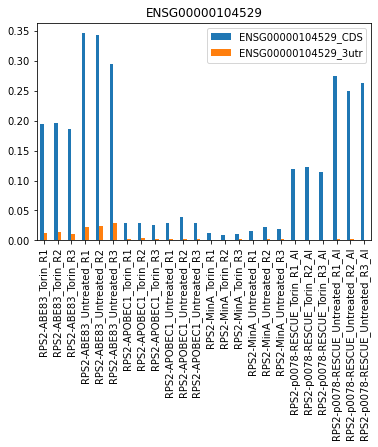

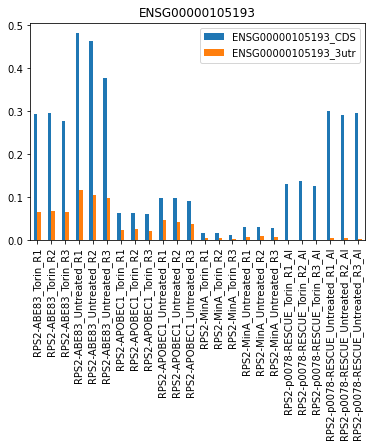

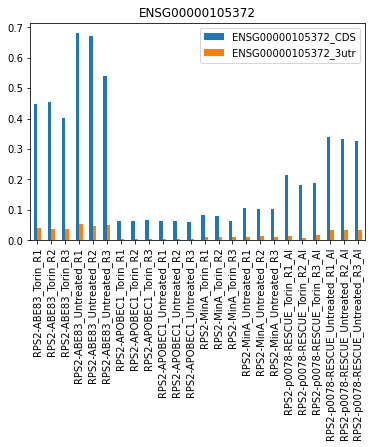

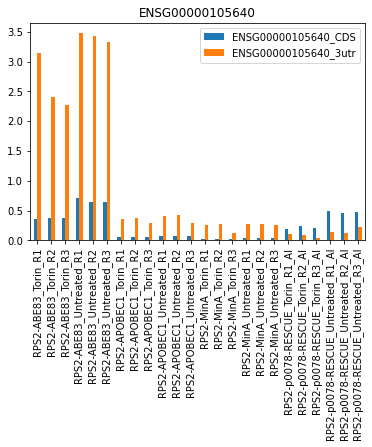

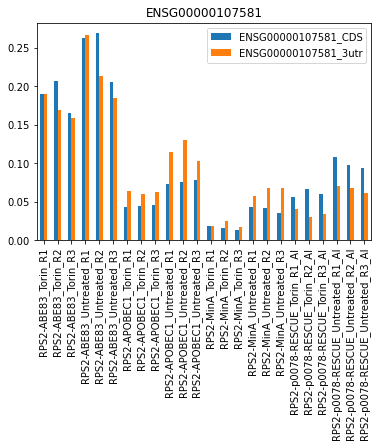

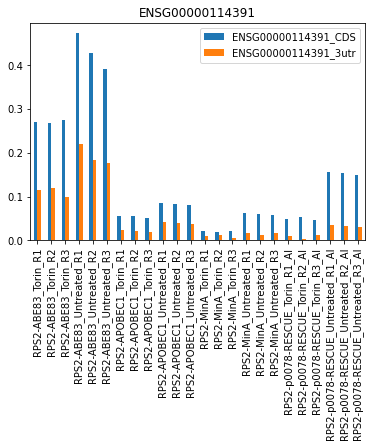

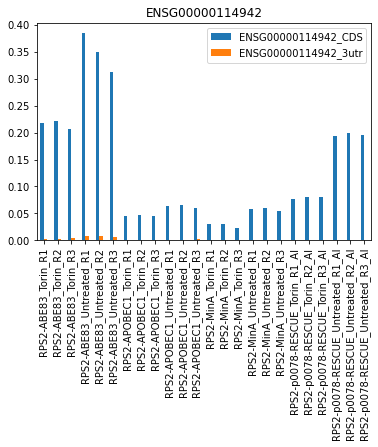

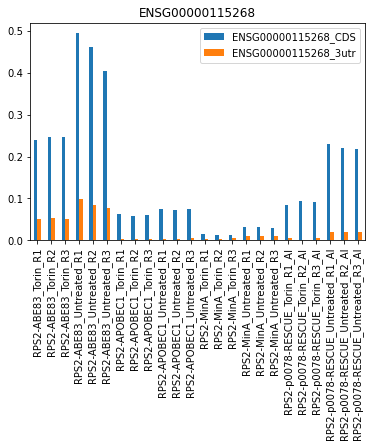

In [71]:
for i in metric_cds_3_all_joined_TOP.loc[[i for i in metric_cds_3_all_joined_TOP.index if 'CDS' in i]].head(20).index:
    #print(i)
    try:
        metric_cds_3_all_joined_TOP.loc[[i, i.replace('_CDS', '_3utr')]].T.drop('length').plot(kind='bar')
        plt.title(i.split('_')[0])
    except Exception as e:
        pass

In [72]:
# T-tests of change in ratio

categories = {'RPS2-APOBEC1':
                  {'Torin':
                      ['RPS2-APOBEC1_Torin_R1', 'RPS2-APOBEC1_Torin_R2','RPS2-APOBEC1_Torin_R3'],
                  'Untreated':
                      ['RPS2-APOBEC1_Untreated_R1','RPS2-APOBEC1_Untreated_R2', 'RPS2-APOBEC1_Untreated_R3']
                  },
              'RPS2-ABE83':
                  {'Torin':
                      ['RPS2-ABE83_Torin_R1','RPS2-ABE83_Torin_R2', 'RPS2-ABE83_Torin_R3'],
                  'Untreated':
                      ['RPS2-ABE83_Untreated_R1', 'RPS2-ABE83_Untreated_R2', 'RPS2-ABE83_Untreated_R3']
                  },
               'RPS2-MinA':
                   {'Torin':
                        ['RPS2-MinA_Torin_R1', 'RPS2-MinA_Torin_R2', 'RPS2-MinA_Torin_R3'],
                    'Untreated':
                        ['RPS2-MinA_Untreated_R1', 'RPS2-MinA_Untreated_R2','RPS2-MinA_Untreated_R3']
                   },
                'RPS20-p0078-RESCUE':
                   {'Torin': ['RPS2-p0078-RESCUE_Torin_R1_AI','RPS2-p0078-RESCUE_Torin_R3_AI'],
                    'Untreated': ['RPS2-p0078-RESCUE_Untreated_R1_AI','RPS2-p0078-RESCUE_Untreated_R2_AI','RPS2-p0078-RESCUE_Untreated_R3_AI']
                   }
             }


In [105]:
metric_cds_3_all_joined[[c for c in metric_cds_3_all_joined.columns if '_R' in c and 'alone' not in c]].to_csv(
    'processed_EPR_values/epr_cds_3_fusion_joined.tsv', sep='\t', index=True
)

In [74]:
untreated_means = []
for k, treatments in categories.items():
    print(k)
    torin_cats = treatments.get("Torin")
    untreated_cats = treatments.get("Untreated")
    
    if k in metric_cds_3_all_joined.columns:
        metric_cds_3_all_joined = metric_cds_3_all_joined.drop(k, axis=1)
        
    new_column = pd.DataFrame(np.log(metric_cds_3_all_joined[torin_cats].mean(axis=1)+1) - np.log(metric_cds_3_all_joined[untreated_cats].mean(axis=1)+1), columns=[k])
        
    untreated_means.append(metric_cds_3_all_joined[untreated_cats].mean(axis=1))
    metric_cds_3_all_joined = metric_cds_3_all_joined.join(new_column, how='inner')


RPS2-APOBEC1
RPS2-ABE83
RPS2-MinA
RPS20-p0078-RESCUE


In [75]:
untreated_means_df = pd.concat(untreated_means, axis=1)
untreated_means_df.columns = categories.keys()

In [76]:
untreated_means_df_3utr = untreated_means_df.loc[[i for i in untreated_means_df.index if '3utr' in i]]
untreated_means_df_cds = untreated_means_df.loc[[i for i in untreated_means_df.index if 'CDS' in i]]

In [77]:
untreated_means_df_3utr.index = [i.split('_')[0] for i in untreated_means_df_3utr.index]
untreated_means_df_cds.index = [i.split('_')[0] for i in untreated_means_df_cds.index]

In [78]:
untreated_means_3utr_and_cds = untreated_means_df_3utr.join(untreated_means_df_cds, lsuffix='_3utr', rsuffix='_CDS')

Text(0.5, 1.0, 'EPR Correlations')

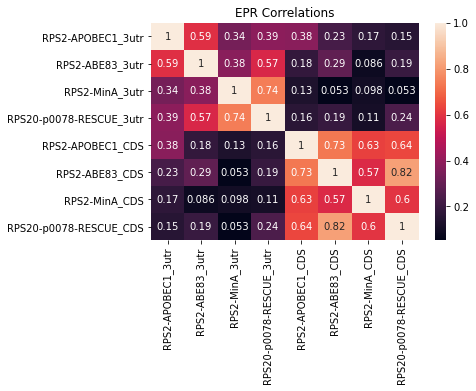

In [79]:
sns.heatmap(untreated_means_3utr_and_cds.corr(), annot=True)
plt.title("EPR Correlations")
#plt.savefig("images/svgs/epr_correlations_3utr_and_cds_across_fusions.svg", bbox_inches='tight')

RPS2-APOBEC1
RPS2-ABE83
RPS2-MinA
RPS20-p0078-RESCUE


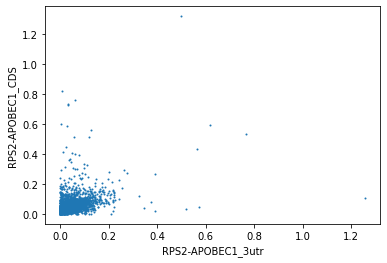

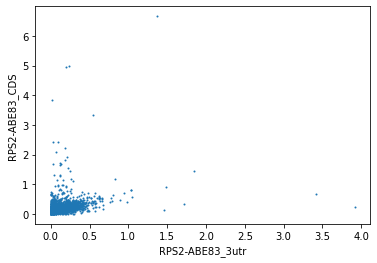

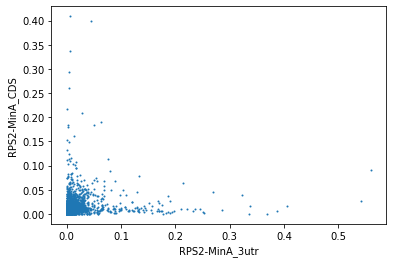

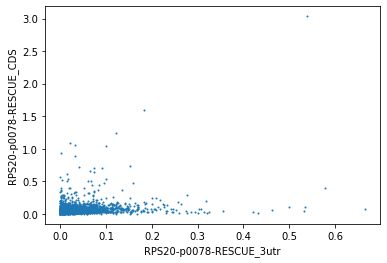

In [80]:
for k in categories.keys():
    print(k)
    untreated_means_3utr_and_cds.plot.scatter('{}_3utr'.format(k), '{}_CDS'.format(k), s=1)

In [81]:
metric_cds_3_all_joined_cds_3utr_ratios =  metric_cds_3_all_joined[list(categories.keys())]

In [82]:
metric_3utr_ratio = metric_cds_3_all_joined_cds_3utr_ratios.loc[[i for i in metric_cds_3_all_joined_cds_3utr_ratios.index if '3utr' in i]]
metric_cds_ratio = metric_cds_3_all_joined_cds_3utr_ratios.loc[[i for i in metric_cds_3_all_joined_cds_3utr_ratios.index if 'CDS' in i]]

In [83]:
metric_3utr_ratio.index = [i.split('_')[0] for i in metric_3utr_ratio.index]
metric_cds_ratio.index = [i.split('_')[0] for i in metric_cds_ratio.index]

In [84]:
metric_3utr_and_cds_ratio = metric_3utr_ratio.join(metric_cds_ratio, lsuffix='_3utr', rsuffix='_CDS')

In [85]:
metric_3utr_and_cds_ratio = metric_3utr_and_cds_ratio[sorted(metric_3utr_and_cds_ratio.columns)]

In [86]:
labels = []
for k, treatments in categories.items():
    print(k)
    metric_3utr_and_cds_ratio['{} (CDS ratio - 3utr ratio)'.format(k)] = metric_3utr_and_cds_ratio['{}_CDS'.format(k)] \
    - metric_3utr_and_cds_ratio['{}_3utr'.format(k)] 
    labels.append(k.replace('RPS20', 'RPS2'))

RPS2-APOBEC1
RPS2-ABE83
RPS2-MinA
RPS20-p0078-RESCUE


In [87]:
all_3utr_cds_ratios = metric_3utr_and_cds_ratio[[c for c in metric_3utr_and_cds_ratio.columns if 'ratio' not in c]]
top_3utr_cds_ratios = metric_3utr_and_cds_ratio[metric_3utr_and_cds_ratio.index.isin(top_genes_list_ensg)][
    [c for c in metric_3utr_and_cds_ratio.columns if 'ratio' not in c]]

In [88]:
list_of_all_ratios = []
list_of_top_ratios = []

for k in all_3utr_cds_ratios.columns:
    list_of_all_ratios.append(all_3utr_cds_ratios[k].to_list())
    list_of_all_ratios.append([])
    list_of_top_ratios.append([])
    list_of_top_ratios.append(top_3utr_cds_ratios[k].to_list())
    

Text(0.5, 0, 'Condition and transcript region')

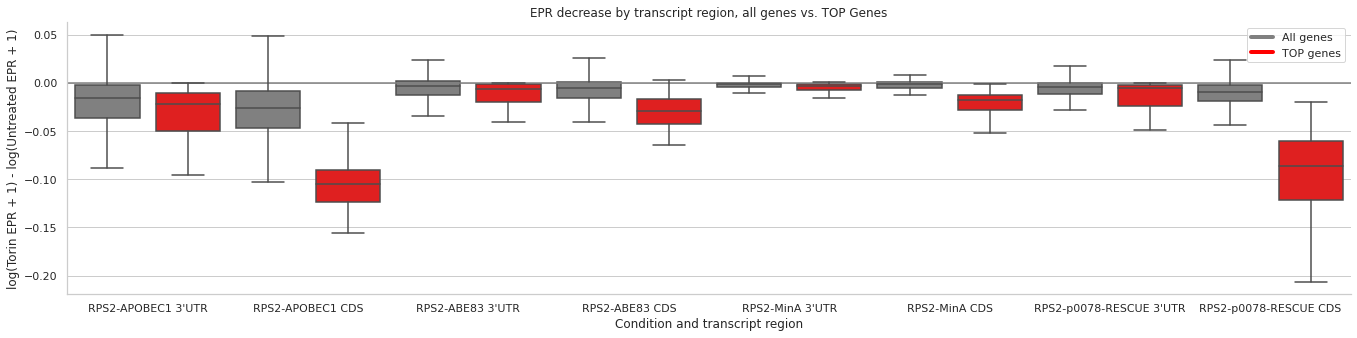

In [89]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1)

plt.figure(figsize=(23, 5))
plt.axhline(0, color='gray')
sns.boxplot(data=list_of_all_ratios, color='gray', showfliers=False)
ax = sns.boxplot(data=list_of_top_ratios, color='#ff0000', showfliers=False)

xticks = [.5, 2.5, 4.5, 6.5, 8.5, 10.5, 12.5, 14.5]

ax.set_xticks(xticks)

xlabels = []
for l in labels:
    xlabels.append("{} 3'UTR".format(l))
    xlabels.append("{} CDS".format(l))

ax.set_xticklabels(xlabels)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray', lw=4),
                Line2D([0], [0], color='#ff0000', lw=4)]


plt.legend(custom_lines, ['All genes', 'TOP genes'])
plt.ylabel("log(Torin EPR + 1) - log(Untreated EPR + 1)")
plt.title("EPR decrease by transcript region, all genes vs. TOP Genes")
plt.xlabel("Condition and transcript region")
#plt.savefig('images/svgs/cds_3utr_epr_ratios/epr_decrease_by_transcript_region_all_vs_top_genes.svg',
#           bbox_inches='tight')

In [90]:
import math

for overall, a in zip(['All', 'TOP'], [list_of_all_ratios, list_of_top_ratios]):
    print('\t', overall)
    for l, label in zip([val for val in a if len(val) > 0], xlabels):
        v = [i for i in l if not math.isnan(i)]
        median = np.median(v)
        if not math.isnan(median):
            print(label, median)

	 All
RPS2-APOBEC1 3'UTR -0.01539782366170328
RPS2-APOBEC1 CDS -0.025824149879222803
RPS2-ABE83 3'UTR -0.0035157754267448743
RPS2-ABE83 CDS -0.0055646180189765195
RPS2-MinA 3'UTR -0.0011480780769847366
RPS2-MinA CDS -0.0016943826879873285
RPS2-p0078-RESCUE 3'UTR -0.0043263454013606865
RPS2-p0078-RESCUE CDS -0.009280717007695739
	 TOP
RPS2-APOBEC1 3'UTR -0.021965861089454808
RPS2-APOBEC1 CDS -0.10479067521359664
RPS2-ABE83 3'UTR -0.006357798167429721
RPS2-ABE83 CDS -0.02880522569764522
RPS2-MinA 3'UTR -0.0032133052495042494
RPS2-MinA CDS -0.018223160308763788
RPS2-p0078-RESCUE 3'UTR -0.005242881694188806
RPS2-p0078-RESCUE CDS -0.08656051104358786


<AxesSubplot:>

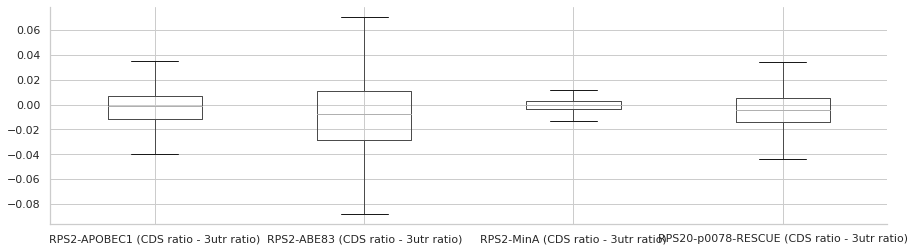

In [91]:
metric_3utr_and_cds_ratio[[c for c in metric_3utr_and_cds_ratio.columns if 'ratio' in c]].boxplot(figsize=(15, 4), showfliers=False)


<AxesSubplot:>

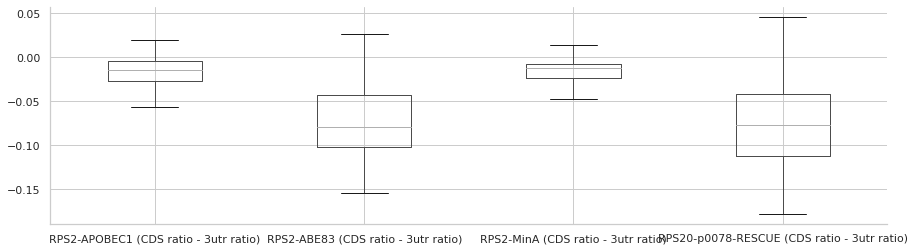

In [92]:
metric_3utr_and_cds_ratio[metric_3utr_and_cds_ratio.index.isin(top_genes_list_ensg)][
    [c for c in metric_3utr_and_cds_ratio.columns if 'ratio' in c]].boxplot(figsize=(15, 4), showfliers=False)


In [93]:

from scipy.stats import ttest_ind, mannwhitneyu

for enzyme, conditions in categories.items():
    torin_reps = conditions.get('Torin')
    untreated_reps = conditions.get('Untreated')
    
    print(enzyme)
    
    torin_cols = metric_cds_3_all_joined_ratio[torin_reps]
    untreated_cols = metric_cds_3_all_joined_ratio[untreated_reps]
    
    print(torin_reps, untreated_reps)
    
    print('\tALL:', mannwhitneyu(torin_cols.mean(axis=1), 
                              untreated_cols.mean(axis=1)))
    print('Factor:',     untreated_cols.mean(axis=1).mean()/torin_cols.mean(axis=1).mean())
    #plt.hist(torin_cols.mean(axis=1), bins=200)
    #plt.hist(untreated_cols.mean(axis=1), bins=200)
    #plt.figure()
    
    print('\tTOP:', mannwhitneyu(torin_cols[torin_cols.index.isin(top_genes_list_ensg)].mean(axis=1), 
                              untreated_cols[untreated_cols.index.isin(top_genes_list_ensg)].mean(axis=1)))

    print('Factor:', untreated_cols[untreated_cols.index.isin(top_genes_list_ensg)].mean(axis=1).mean()/ 
          torin_cols[torin_cols.index.isin(top_genes_list_ensg)].mean(axis=1).mean())
    

RPS2-APOBEC1
['RPS2-APOBEC1_Torin_R1', 'RPS2-APOBEC1_Torin_R2', 'RPS2-APOBEC1_Torin_R3'] ['RPS2-APOBEC1_Untreated_R1', 'RPS2-APOBEC1_Untreated_R2', 'RPS2-APOBEC1_Untreated_R3']
	ALL: MannwhitneyuResult(statistic=5948367.0, pvalue=0.013525787151145873)
Factor: 1.4696539785465954
	TOP: MannwhitneyuResult(statistic=2481.0, pvalue=0.067075563884571)
Factor: 0.5912236922599724
RPS2-ABE83
['RPS2-ABE83_Torin_R1', 'RPS2-ABE83_Torin_R2', 'RPS2-ABE83_Torin_R3'] ['RPS2-ABE83_Untreated_R1', 'RPS2-ABE83_Untreated_R2', 'RPS2-ABE83_Untreated_R3']
	ALL: MannwhitneyuResult(statistic=5816982.0, pvalue=8.397373285921607e-05)
Factor: 1.2755621588358448
	TOP: MannwhitneyuResult(statistic=2072.0, pvalue=0.0013275778990177386)
Factor: 1.6505869628313625
RPS2-MinA
['RPS2-MinA_Torin_R1', 'RPS2-MinA_Torin_R2', 'RPS2-MinA_Torin_R3'] ['RPS2-MinA_Untreated_R1', 'RPS2-MinA_Untreated_R2', 'RPS2-MinA_Untreated_R3']
	ALL: MannwhitneyuResult(statistic=5989037.5, pvalue=0.04178762153795912)
Factor: 0.7395264296089008
	T

(-0.5, 0.5)

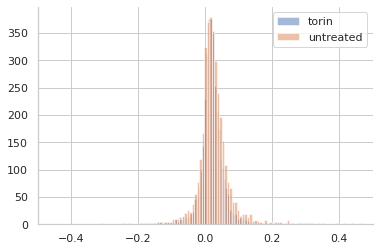

In [94]:
plt.hist(torin_cols.mean(axis=1), bins=1000, alpha=0.5)
plt.hist(untreated_cols.mean(axis=1), bins=1000, alpha=0.5)
plt.legend(['torin', 'untreated'])
plt.xlim(-.5, .5)

(-0.5, 0.5)

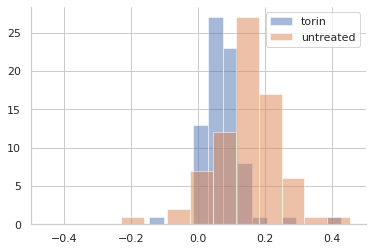

In [95]:
plt.hist(torin_cols[torin_cols.index.isin(top_genes_list_ensg)].mean(axis=1), bins=40, alpha=0.5)
plt.hist(untreated_cols[untreated_cols.index.isin(top_genes_list_ensg)].mean(axis=1), bins=40, alpha=0.5)
plt.legend(['torin', 'untreated'])
plt.xlim(-.5, .5)

# T-tests to test for differences between conditions

In [111]:
from collections import defaultdict 

conditions_ct = set()
conditions_ai = set()

condition_replicate_labels_ct = defaultdict(lambda:{})
condition_replicate_labels_78 = defaultdict(lambda:{})

which = '_1_'
metric_df_ct = metric_df_ct[[c for c in metric_df_ct.columns if which in c]]
for c in metric_df_ct.columns:
    if which in c:
        if 'R1' in c:
            replicate = 'R1'
        elif 'R2' in c:
            replicate = 'R2'
        elif 'R3' in c:
            replicate = 'R3'

        experiment = '_'.join(c.split('_{}{}'.format(replicate, which)))
        

        conditions_ct.add(experiment)

        condition_replicate_labels_ct[experiment][replicate] = c

        if '78' in c:
            condition_replicate_labels_78[experiment][replicate] = c
        
condition_replicate_labels_ai = defaultdict(lambda:{})
    
which = '_1_'
for c in metric_df_ai.columns:
    if which in c:
        if 'R1' in c:
            replicate = 'R1'
        elif 'R2' in c:
            replicate = 'R2'
        elif 'R3' in c:
            replicate = 'R3'

        experiment = '_'.join(c.split('_{}{}'.format(replicate, which)))
        conditions_ai.add(experiment)

        condition_replicate_labels_ai[experiment][replicate] = c
        
        if '78' in c:
            condition_replicate_labels_78[experiment][replicate] = c

In [112]:
for k in condition_replicate_labels_78:
    if 'Torin' in k:
        print('"{}"'.format(k.split('_Torin')[0]), ': ["{}\", "{}"],'.format(k, k.replace('Torin', 'Untreated')))

"RPS2-p0078-RESCUE" : ["RPS2-p0078-RESCUE_Torin", "RPS2-p0078-RESCUE_Untreated"],
"p0078_RESCUE_alone" : ["p0078_RESCUE_alone_Torin", "p0078_RESCUE_alone_Untreated"],


In [113]:
from scipy.stats import ttest_ind

def ttest(r, treated_rep_cols, untreated_rep_cols):
    treated_vals = []
    untreated_vals = []
    
    rep_list = ['R1', 'R2', 'R3']
    for rep in rep_list:
        if rep in treated_rep_cols:
            treated_vals.append(float(r.loc[treated_rep_cols.get(rep)]))
        else:
            pass
            
        if rep in untreated_rep_cols:
            untreated_vals.append(float(r.loc[untreated_rep_cols.get(rep)]))
        else:
            pass
    
    mean_treated = np.mean(treated_vals)
    mean_untreated = np.mean(untreated_vals)
    
    log2foldchange = np.log2(mean_treated + 1) - np.log2(mean_untreated + 1)
    result = ttest_ind(treated_vals, untreated_vals)
    pval = -np.log10(result[1])
    return (mean_untreated, mean_treated, log2foldchange, result[0], result[1], pval)

In [114]:
# Combine p0078 ct and ai edits

metrics_ct_78 = metric_df_ct[[c for c in metric_df_ct.columns if '78' in c and 'log' not in c and 'pval' not in c and 'mean' not in c and 'stat' not in c]]
metrics_ai_78 = metric_df_ai[[c for c in metric_df_ai.columns if '_1_' in c and '78' in c and 'log' not in c and 'pval' not in c and 'mean' not in c and 'stat' not in c]]

metrics_ct_78 = metrics_ct_78[~metrics_ct_78.index.isna()]
metrics_ai_78 = metrics_ai_78[~metrics_ai_78.index.isna()]
metrics_78_combined = metrics_ct_78.join(metrics_ai_78, lsuffix='_CT', rsuffix='_AI', how='outer').fillna(0)


col_label_set = set([c[0:-3] for c in metrics_78_combined.columns])

new_combined_columns = []
for label in col_label_set:
    ct_ai = metrics_78_combined[['{}_CT'.format(label), '{}_AI'.format(label)]]

    combined_column = pd.DataFrame(ct_ai.sum(axis=1), columns=[label])
    new_combined_columns.append(combined_column)
    
metric_df_78 = pd.concat(new_combined_columns, axis=1)

In [115]:
comparisons_ct = {
    'APOBEC1_alone': ['APOBEC1_alone_Torin', 'APOBEC1_alone_Untreated'],
    'RPS2-APOBEC1': ['RPS2-APOBEC1_Torin', 'RPS2-APOBEC1_Untreated'],
}    

comparisons_ai = {
    "ABE8e_alone" : ["ABE8e_alone_Torin", "ABE8e_alone_Untreated"],
    "MinA_alone" : ["MinA_alone_Torin", "MinA_alone_Untreated"],
    "RPS2-ABE83" : ["RPS2-ABE83_Torin", "RPS2-ABE83_Untreated"],
    "RPS2-MinA" : ["RPS2-MinA_Torin", "RPS2-MinA_Untreated"],
}


comparisons_78 = {'RPS2-p0078-RESCUE': ['RPS2-p0078-RESCUE_Torin',
  'RPS2-p0078-RESCUE_Untreated'],
 'p0078_RESCUE_alone': ['p0078_RESCUE_alone_Torin',
  'p0078_RESCUE_alone_Untreated']}

In [116]:
metric_df_ct = metric_df_ct[[c for c in metric_df_ct if '78' not in c]]
metric_df_ai = metric_df_ai[[c for c in metric_df_ai if '78' not in c]]

In [117]:
for comparison, metrics_df, condition_replicate_labels in zip([comparisons_ct, comparisons_ai, comparisons_78], 
                                  [metric_df_ct, metric_df_ai, metric_df_78],
                                  [condition_replicate_labels_ct, condition_replicate_labels_ai,
                                  condition_replicate_labels_78]
                                 ):
    for comparison_label, cols in comparison.items():
        print(comparison_label)
        treated_rep_cols = condition_replicate_labels.get(cols[0])
        untreated_rep_cols = condition_replicate_labels.get(cols[1])

        metrics_df['{}_mean_untreated'.format(comparison_label)],\
        metrics_df['{}_mean_treated'.format(comparison_label)],\
        metrics_df['{}_log2_fold_change'.format(comparison_label)],\
        metrics_df['{}_stat'.format(comparison_label)], \
        metrics_df['{}_pvalue'.format(comparison_label)], \
        metrics_df['{}_neg_log_pvalue'.format(comparison_label)] = zip(*metrics_df.apply(ttest, args=(treated_rep_cols, untreated_rep_cols,), axis=1))



APOBEC1_alone
RPS2-APOBEC1
ABE8e_alone


/home/ekofman/new_anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


MinA_alone
RPS2-ABE83
RPS2-MinA
RPS2-p0078-RESCUE
p0078_RESCUE_alone


In [134]:
combined_metrics_df = metric_df_78[[c for c in metric_df_78.columns if '_R' not in c and 'alone' not in c]]\
.join(metric_df_ai[[c for c in metric_df_ai.columns if '_R' not in c and 'alone' not in c]])\
.join(metric_df_ct[[c for c in metric_df_ct.columns if '_R' not in c and 'alone' not in c]], how='inner')


In [143]:
combined_metrics_df[sorted(combined_metrics_df.columns, reverse=True)].to_csv('processed_EPR_values/epr_volcano_plot_values.tsv',
                                                                             sep='\t', index=True)

# Look at volcano plots, filter by EPR?

In [69]:
top_genes = 'PABPC1,EIF4B,EIF3A,EIF3E,NAP1L1,VIM,EIF3F,EEF1A1,EEF1B2,EEF1G,EEF1D,EEF2,RACK1,NPM1,TPT1,RPL22,RPL3,RPSA,RPS2,RPS3,RPS3A,RPS4X,RPS4Y1,RPS5,RPS6,RPS7,RPS8,RPS9,RPS10,RPS11,RPS12,RPS13,RPS14,RPS15,RPS15A,RPS16,RPS17,RPS18,RPS19,RPS20,RPS21,RPS23,RPS24,RPS25,RPS26,RPS27,RPS27A,RPS28,RPS29,FAU,RPLP0,RPLP1,RPLP2,RPL3,RPL4,RPL5,RPL6,RPL7,RPL7A,RPL8,RPL9,RPL10,RPL11,RPL10A,RPL12,RPL13,RPL13A,RPL14,RPL15,RPL17,RPL18,RPL18A,RPL19,RPL21,RPL22,RPL23,RPL23A,RPL24,RPL26,RPL27,RPL27A,RPL30,RPL31,RPL32,RPL34,RPL35,RPL36,RPL36A,RPL37,RPL39,UBA52,RPL41'
top_genes_list = top_genes.split(',')

RPS2-APOBEC1
972 75
RPS2-ABE83
1188 75
RPS2-MinA
657 75
RPS2-p0078-RESCUE
947 77


{'RPS2-APOBEC1': {'ttest_stat': 4.242499177299662,
  'ttest_pval': 2.4065412766668553e-05},
 'RPS2-ABE83': {'ttest_stat': 9.431159273388309,
  'ttest_pval': 1.877427880852462e-20},
 'RPS2-MinA': {'ttest_stat': 3.4441996202504903,
  'ttest_pval': 0.0006054605548082772},
 'RPS2-p0078-RESCUE': {'ttest_stat': 14.846137144690491,
  'ttest_pval': 2.6983701742690743e-45}}

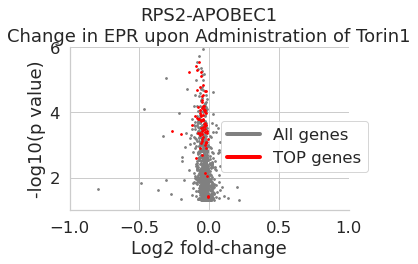

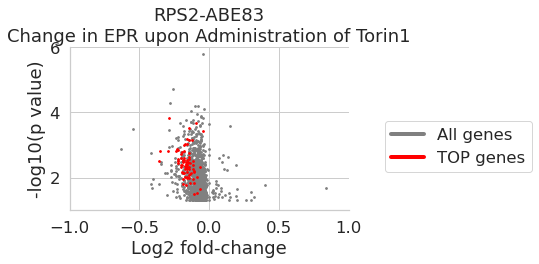

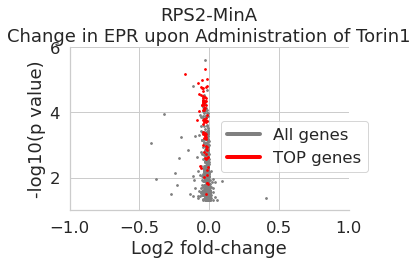

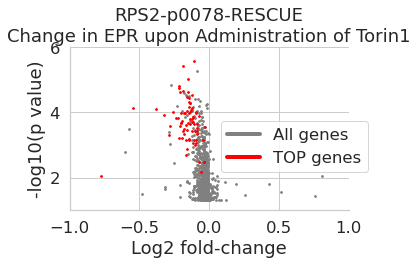

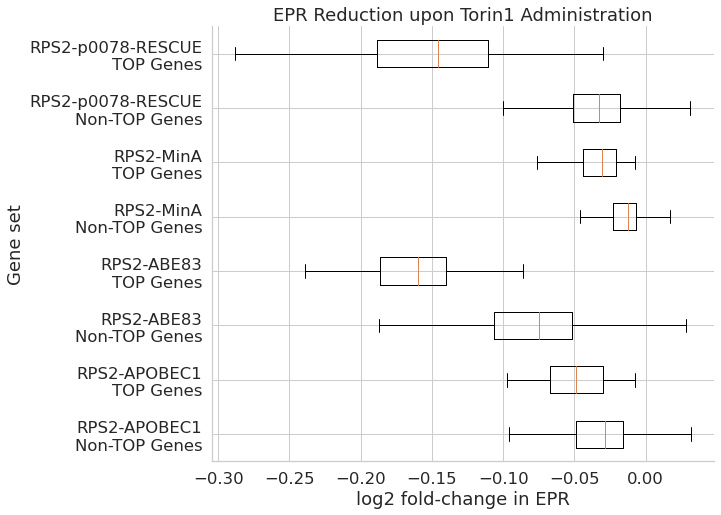

In [70]:
from scipy.stats import ttest_ind
from matplotlib import pyplot as plt
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

min_quantile = 0

values_list = []
labels_list = []

ttest_stats = {}

edited_list = {}
edited_gene_list = {}

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='gray', lw=4),
                Line2D([0], [0], color='red', lw=4)]
        
for comparisons, metrics in zip([comparisons_ct, comparisons_ai, comparisons_78], 
                                [metric_df_ct, metric_df_ai, metric_df_78]):
    labels = comparisons.keys()
    
    for label in labels:
        if 'alone' in label:
            continue
        print(label)
        
        genes_upedited = list(metrics[(metrics['{}_log2_fold_change'.format(label)] > 0) \
                 & (metrics['{}_pvalue'.format(label)] < 0.05)].index)
        genes_downedited = list(metrics[(metrics['{}_log2_fold_change'.format(label)] < 0) \
                         & (metrics['{}_pvalue'.format(label)] < 0.05)].index)
        genes_not_edited = list(metrics[metrics['{}_pvalue'.format(label)] >= 0.05].index)
        
        edited_list[label] = {'Higher EPR': len(genes_upedited), 'Lower EPR': len(genes_downedited), 'Non significant': len(genes_not_edited)}
        edited_gene_list[label] = {'Higher EPR': set(genes_upedited), 'Lower EPR': set(genes_downedited), 'Non significant': genes_not_edited}
        # filter by quantile
        untreated_label = '{}_mean_treated'.format(label)
        metrics_filtered = metrics[metrics[untreated_label] > metrics[untreated_label].quantile(min_quantile)]
    
        # filter by pvalues
        pvalue_label = '{}_pvalue'.format(label)
        metrics_filtered = metrics_filtered[metrics_filtered[pvalue_label] < 0.05]
        
        non_top_gene_metrics = metrics_filtered[~metrics_filtered.index.isin(top_genes_list)]
        top_gene_metrics = metrics_filtered[metrics_filtered.index.isin(top_genes_list)]
        
        print(len(non_top_gene_metrics), len(top_gene_metrics))
        # Volcano plot
        
        plt.figure(figsize=(5, 3))
        plt.scatter(non_top_gene_metrics['{}_log2_fold_change'.format(label)], 
                    non_top_gene_metrics['{}_neg_log_pvalue'.format(label)], s=3, color='gray')
                    
        plt.scatter(top_gene_metrics['{}_log2_fold_change'.format(label)],
                    top_gene_metrics['{}_neg_log_pvalue'.format(label)], s=3, color='red')
        plt.xlabel("Log2 fold-change")
        plt.ylabel("-log10(p value)")
        


        plt.legend(custom_lines, ['All genes', 'TOP genes'], bbox_to_anchor=(1.1, .6))
        
        plt.title("{}\nChange in {} upon Administration of Torin1".format(label, metric.upper()))
        plt.xlim(-1, 1)
        plt.ylim(1, 6)
        
        plt.savefig('images/svgs/top_genes_reductions/log2_fc_epr_volcano_{}.svg'.format(label), bbox_inches='tight')

        # Add boxplot values
        lists_to_test = [non_top_gene_metrics['{}_log2_fold_change'.format(label)].to_list(),
                                     top_gene_metrics['{}_log2_fold_change'.format(label)].to_list()]
        values_list = values_list + lists_to_test
        labels_list = labels_list + ['{}\nNon-TOP Genes'.format(label), '{}\nTOP Genes'.format(label)]
        
        ttest_stat, ttest_pval  = ttest_ind(lists_to_test[0], lists_to_test[1])
        ttest_stats[label] = {'ttest_stat': ttest_stat, 'ttest_pval': ttest_pval}
        
plt.figure(figsize=(9, 8))
p = plt.boxplot(values_list, vert=False, labels=labels_list, showfliers=False)
plt.xlabel("log2 fold-change in EPR")
plt.ylabel("Gene set")
plt.title("{} Reduction upon Torin1 Administration".format(metric.upper()))
plt.savefig('images/svgs/top_genes_reductions/log2_fc_epr_across_enzymes.svg', bbox_inches='tight')
ttest_stats

In [71]:
edited_list

{'RPS2-APOBEC1': {'Higher EPR': 118,
  'Lower EPR': 933,
  'Non significant': 3190},
 'RPS2-ABE83': {'Higher EPR': 38, 'Lower EPR': 1225, 'Non significant': 2958},
 'RPS2-MinA': {'Higher EPR': 39, 'Lower EPR': 707, 'Non significant': 3393},
 'RPS2-p0078-RESCUE': {'Higher EPR': 57,
  'Lower EPR': 970,
  'Non significant': 3468}}

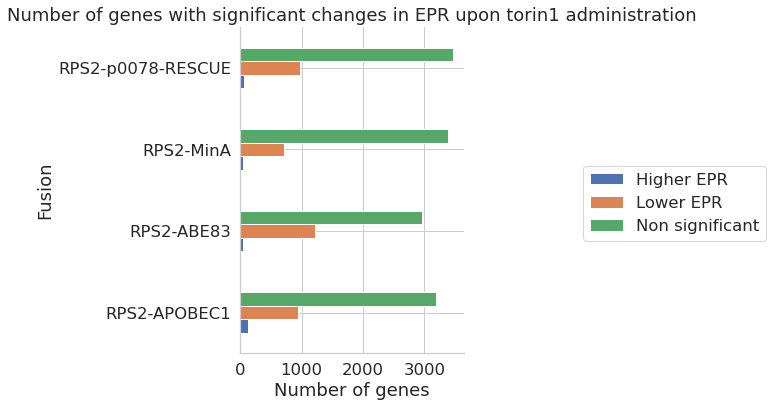

In [72]:
pd.DataFrame(edited_list).T.plot(kind='barh', figsize=(4, 6))
plt.title("Number of genes with significant changes in EPR upon torin1 administration")
plt.xlabel("Number of genes")
plt.ylabel("Fusion")
plt.legend(bbox_to_anchor=(1.5, .6))
plt.savefig('images/svgs/top_genes_reductions/num_genes_significant_epr_changes_up_and_down_barplot.svg', bbox_inches='tight')


### look at specific genes

In [73]:
for k, v in edited_gene_list.items():
    print(k)

RPS2-APOBEC1
RPS2-ABE83
RPS2-MinA
RPS2-p0078-RESCUE


In [74]:
edited_list

{'RPS2-APOBEC1': {'Higher EPR': 118,
  'Lower EPR': 933,
  'Non significant': 3190},
 'RPS2-ABE83': {'Higher EPR': 38, 'Lower EPR': 1225, 'Non significant': 2958},
 'RPS2-MinA': {'Higher EPR': 39, 'Lower EPR': 707, 'Non significant': 3393},
 'RPS2-p0078-RESCUE': {'Higher EPR': 57,
  'Lower EPR': 970,
  'Non significant': 3468}}

In [75]:
len(edited_gene_list.get('RPS2-APOBEC1').get('Higher EPR')), len(edited_gene_list.get('RPS2-APOBEC1').get('Lower EPR'))

(118, 933)

In [76]:
len(edited_gene_list.get('RPS2-ABE83').get('Higher EPR')), len(edited_gene_list.get('RPS2-ABE83').get('Lower EPR'))

(38, 1225)

In [77]:
len(edited_gene_list.get('RPS2-MinA').get('Higher EPR')), len(edited_gene_list.get('RPS2-MinA').get('Lower EPR'))

(39, 707)

In [78]:
len(edited_gene_list.get('RPS2-p0078-RESCUE').get('Higher EPR')), len(edited_gene_list.get('RPS2-p0078-RESCUE').get('Lower EPR'))

(57, 970)

In [79]:
order = [o for o in reversed(['RPS2-ABE83',  'RPS2-p0078-RESCUE', 'RPS2-APOBEC1', 'RPS2-MinA'])]

In [80]:
order

['RPS2-MinA', 'RPS2-APOBEC1', 'RPS2-p0078-RESCUE', 'RPS2-ABE83']

In [81]:
#from upsetplot import UpSet

#UpSet(top_example)

In [82]:
#plot(top_example)

In [301]:
len(edited_gene_list.get('RPS2-APOBEC1').get('Higher EPR'))

118

In [302]:
len(edited_gene_list.get('RPS2-APOBEC1').get('Lower EPR'))

933

hiiii
hiiii
hiiii


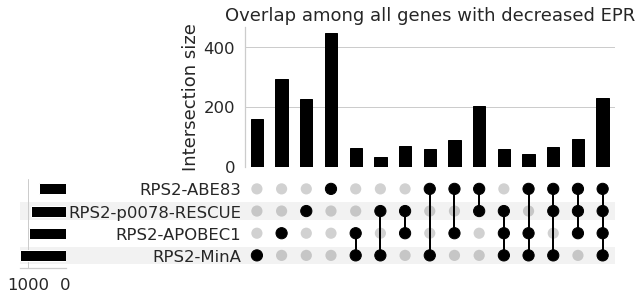

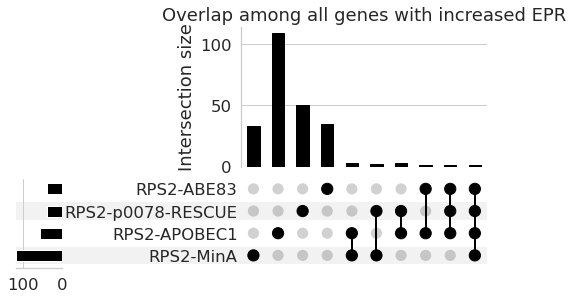

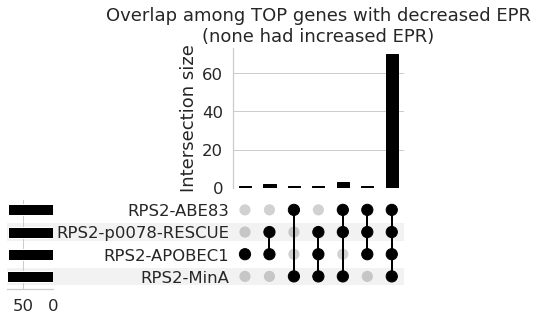

In [303]:
from upsetplot import plot
from upsetplot import generate_counts

from upsetplot import from_contents

contents = {k:v.get('Lower EPR') for k,v in edited_gene_list.items()}
all_decreased_example = from_contents(contents).reorder_levels(order)

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 8))

plot(all_decreased_example, fig=fig)
plt.title("Overlap among all genes with decreased EPR")
plt.savefig('images/svgs/top_genes_reductions/all_gene_level_overlap_across_enzymes_decreased.svg', bbox_inches='tight')


contents = {k:v.get('Higher EPR') for k,v in edited_gene_list.items()}
all_increased_example = from_contents(contents).reorder_levels(order)

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 8))

plot(all_increased_example, fig=fig)
plt.title("Overlap among all genes with increased EPR")
plt.savefig('images/svgs/top_genes_reductions/all_gene_level_overlap_across_enzymes_increased.svg', bbox_inches='tight')




contents = {k:[g for g in v.get('Lower EPR') if g in top_genes_list] for k,v in edited_gene_list.items()}
top_example = from_contents(contents).reorder_levels(order)

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12, 8))

plot(top_example, fig=fig)
plt.title("Overlap among TOP genes with decreased EPR\n(none had increased EPR)")
plt.savefig('images/svgs/top_genes_reductions/TOP_gene_level_overlap_across_enzymes_decreased.svg', bbox_inches='tight')


In [305]:
all_decreased_example

id
RPS2-MinA RPS2-APOBEC1 RPS2-p0078-RESCUE RPS2-ABE83         
True      True         True              True          SNRPA
False     True         False             False         FGFR1
True      True         True              True         HNRNPK
False     True         False             False          CRBN
                                         True         DCAF13
...                                                      ...
          False        True              False       PPP1R37
                                         False         GSK3A
                                         False        WRNIP1
                                         False        HECTD1
                                         False          BOP1

[2122 rows x 1 columns]

In [306]:
vals = pd.DataFrame([list(all_increased_example.index.get_level_values(0)),
list(all_increased_example.index.get_level_values(1)),
list(all_increased_example.index.get_level_values(2)),
list(all_increased_example.index.get_level_values(3))]).T

In [307]:
vals.columns = order

# Output overlap lists

In [308]:
all_decreased_example.to_csv('5_decreased_gene_overlaps/gene_overlap_by_enzyme.tsv', sep='\t')

In [309]:
boolean_version = pd.read_csv('5_decreased_gene_overlaps/gene_overlap_by_enzyme.tsv', sep='\t')

In [310]:
boolean_version.index = boolean_version.id

In [311]:
boolean_version = boolean_version.drop('id', axis=1)

In [312]:
boolean_version.loc[boolean_version.sum(axis=1) == 1].to_csv('5_decreased_gene_overlaps/gene_overlap_by_enzyme_exclusive_to_one_enzyme.tsv', 
                                                             sep='\t')

In [313]:
boolean_version

,RPS2-MinA,RPS2-APOBEC1,RPS2-p0078-RESCUE,RPS2-ABE83
id,,,,
SNRPA,True,True,True,True
FGFR1,False,True,False,False
HNRNPK,True,True,True,True
CRBN,False,True,False,False
DCAF13,False,True,False,True
...,...,...,...,...
PPP1R37,False,False,True,False
GSK3A,False,False,True,False
WRNIP1,False,False,True,False


# GC content of genes exclusive to one enzyme

In [340]:
import pybedtools

fasta = '/projects/ps-yeolab3/ekofman/ReferenceData/hg38/cellranger-GRCh38-3.0.0/fasta/genome.fa'
hg38_genes ='/projects/ps-yeolab3/ekofman/ReferenceData/hg38/cellranger-GRCh38-3.0.0/genes/genes.gtf'

hg38_cds = '/projects/ps-yeolab3/ekofman/ReferenceData/hg38/cellranger-GRCh38-3.0.0/safs/genes.CDS_only.SAF'

#hg38_cds = '/projects/ps-yeolab3/ekofman/ReferenceData/hg38/cellranger-GRCh38-3.0.0/safs/genes.CDS_plus_3utr.SAF'

In [341]:
hg38_cds_df = pd.read_csv(hg38_cds, sep='\t')[['Chr', 'Start', 'End', 'GeneID', 'GeneID', 'Strand']]

/home/ekofman/new_anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [342]:
hg38_cds_df = hg38_cds_df[hg38_cds_df.Start != hg38_cds_df.End]

In [343]:
hg38_bedtools = pybedtools.BedTool.from_dataframe(hg38_cds_df)

In [344]:
content_info = hg38_bedtools.nucleotide_content(fi=fasta, s=True)

In [345]:
content_info_df = content_info.to_dataframe()

/home/ekofman/new_anaconda3/lib/python3.7/site-packages/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 15 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())
/home/ekofman/new_anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [346]:
content_info_df.columns = ['chrom', 'start', 'end', 'ensg', 'ensg2', 'strand', 'pct_at', 'pct_gc', 'num_A', 'num_C', 
                           'num_G', 'num_T', 'num_N', 'num_oth', 'seq_len']

In [347]:
total_counts = pd.DataFrame(content_info_df.groupby('ensg').sum())

In [348]:
for c in total_counts.columns:
    if 'num_' in c:
        total_counts['percent_{}'.format(c.split('_')[1])] = total_counts[c]/total_counts['seq_len']

In [349]:
total_percents = total_counts[[c for c in total_counts.columns if 'percent_' in c or 'seq_len' in c]]

In [350]:
total_percents['percent_GC'] = total_percents['percent_C'] + total_percents['percent_G']

/home/ekofman/new_anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [351]:
conversion = pd.read_csv('/projects/ps-yeolab3/ekofman/ReferenceData/enst_ensg_genename.txt', sep='\t')


In [352]:
conversion.index = conversion['Gene stable ID']

In [353]:
total_percents = total_percents.join(conversion[['Gene name']], how='inner').drop_duplicates()

In [354]:
total_percents.index = total_percents['Gene name']

In [355]:
total_percents = total_percents.join(boolean_version, how='inner')

In [356]:
total_percents

,seq_len,percent_A,percent_C,percent_G,percent_T,percent_N,percent_oth,percent_GC,Gene name,RPS2-MinA,RPS2-APOBEC1,RPS2-p0078-RESCUE,RPS2-ABE83
A1BG,2389,0.176643,0.326078,0.322729,0.174550,0.0,0.0,0.648807,A1BG,False,False,True,True
AARS1,3716,0.248385,0.246502,0.287406,0.217707,0.0,0.0,0.533907,AARS1,True,False,True,True
AATF,2576,0.298137,0.224767,0.278339,0.198758,0.0,0.0,0.503106,AATF,False,False,True,False
ABCB9,22975,0.185245,0.315082,0.297889,0.201785,0.0,0.0,0.612971,ABCB9,False,False,False,True
ABCE1,4090,0.334963,0.179707,0.207824,0.277506,0.0,0.0,0.387531,ABCE1,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZRANB1,2115,0.287943,0.190544,0.253901,0.267612,0.0,0.0,0.444444,ZRANB1,False,False,True,False
ZSCAN21,4607,0.285218,0.261341,0.273280,0.180161,0.0,0.0,0.534621,ZSCAN21,False,False,False,True
ZSCAN29,8182,0.291860,0.223417,0.289538,0.195185,0.0,0.0,0.512955,ZSCAN29,True,False,False,False
ZSCAN30,7037,0.297854,0.211596,0.271138,0.219412,0.0,0.0,0.482734,ZSCAN30,False,True,False,False


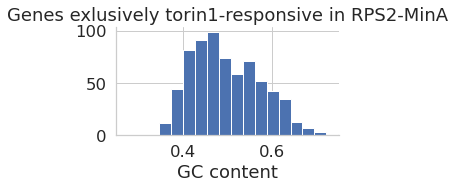

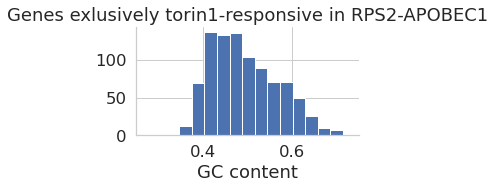

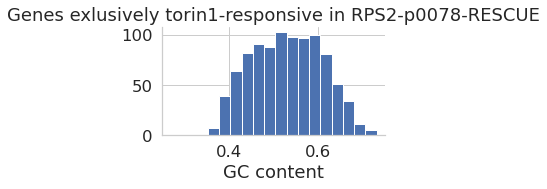

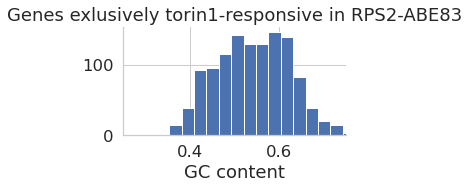

In [362]:

for c in total_percents.columns:
    if 'RPS2' in c:
        plt.figure(figsize=(4, 2))
        legend_text.append(c)
        total_percents[total_percents[c] == True].percent_GC.hist(bins=15)
        plt.xlim(.25, .75)
        plt.xlabel('GC content')
        plt.title('Genes exlusively torin1-responsive in {}'.format(c))


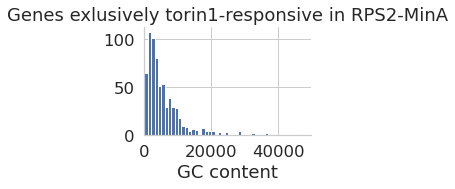

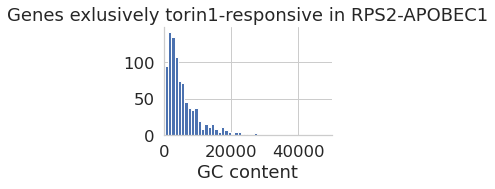

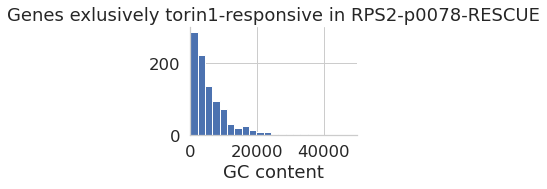

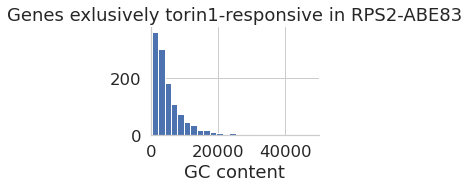

In [358]:

for c in total_percents.columns:
    if 'RPS2' in c:
        plt.figure(figsize=(3, 2))
        legend_text.append(c)
        total_percents[total_percents[c] == True].seq_len.hist(bins=50)
        plt.xlim(0, 50000)
        plt.xlabel('GC content')
        plt.title('Genes exlusively torin1-responsive in {}'.format(c))


# Compare general gene levels across enzymes

In [233]:
all_reps = pd.DataFrame()

for comparisons, metrics in zip([comparisons_ct, comparisons_ai, comparisons_78], 
                                [metric_df_ct, metric_df_ai, metric_df_78]):
    labels = comparisons.keys()
    
    rep_cols = metrics[[c for c in metrics.columns if ('_R1' in c or '_R2' in c or '_R3' in c) and ('_2_' not in c)]]
    rep_cols = rep_cols[~rep_cols.index.isna()]
    if all_reps.empty:
        all_reps = rep_cols
    else:
        all_reps = all_reps.join(rep_cols)
        
all_reps = all_reps.fillna(0)

### Enzyme mean comparison

In [234]:
# get means
rep_mean_lists = defaultdict(lambda:[])

for n, v in all_reps.mean().items():
    if 'alone' in n:
        continue
    if 'R1' in n:
        subs = '_R1_1'
    elif 'R2' in n:
        subs = '_R2_1'
    elif 'R3' in n:
        subs = '_R3_1'
        
    category = n.replace(subs, '')
    rep_mean_lists[category].append(v)
    
rep_mean_box_lists = []
rep_mean_box_labels = []
for k,v in rep_mean_lists.items():
    rep_mean_box_lists.append(v)
    rep_mean_box_labels.append(k)

Text(0, 0.5, 'Condition')

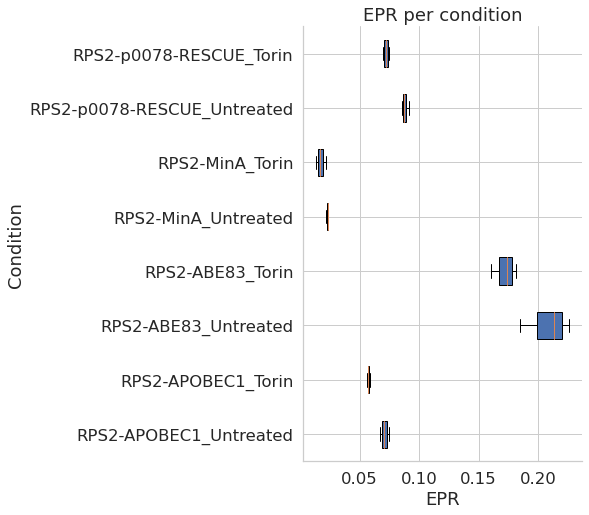

In [235]:
plt.figure(figsize=(5, 8))
p = plt.boxplot(rep_mean_box_lists, labels=rep_mean_box_labels, vert=False, patch_artist=True)
plt.title("{} per condition".format(metric.upper()))
plt.xlabel("{}".format(metric.upper()))
plt.ylabel("Condition")
#plt.savefig('images/svgs/epr_across_conditions.svg', bbox_inches='tight')


In [240]:
[i for i in reversed([np.median(v) for v in rep_mean_box_lists])]

[0.07229136632401369,
 0.08708522680316859,
 0.016863670371454923,
 0.023220079939253485,
 0.17402434929834437,
 0.2134796415714977,
 0.057012391297679856,
 0.07074443621391659]

<AxesSubplot:>

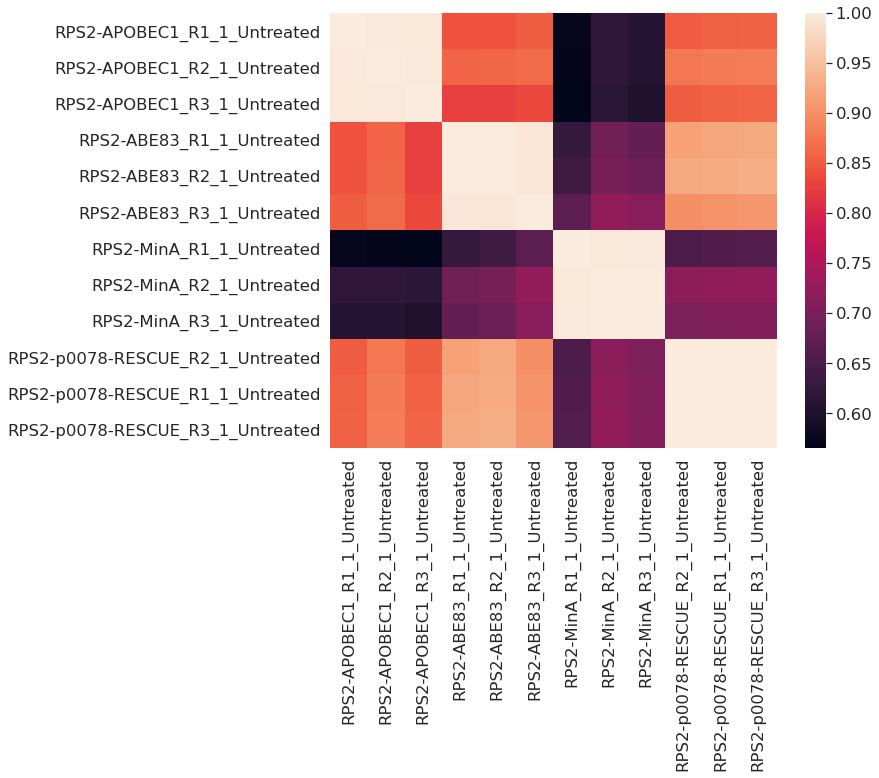

In [76]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(all_reps[[c for c in all_reps.columns if 'alone' not in c and 'Torin' not in c]].corr())

In [77]:
# standardize
#all_reps = all_reps[all_reps.index.isin(top_genes_list)]
all_reps = all_reps/all_reps.sum()

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np


pcs = ['PC1', 'PC2', 'PC3', 'PC4']
x = StandardScaler().fit_transform(all_reps.T)
pca = PCA(n_components=len(pcs))
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = pcs)
principalDf.index = all_reps.columns


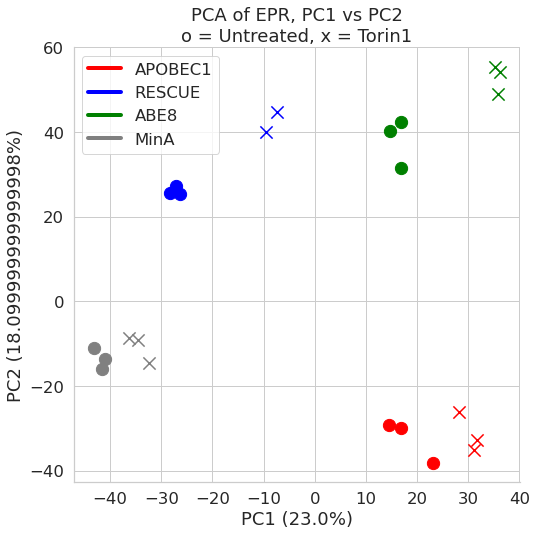

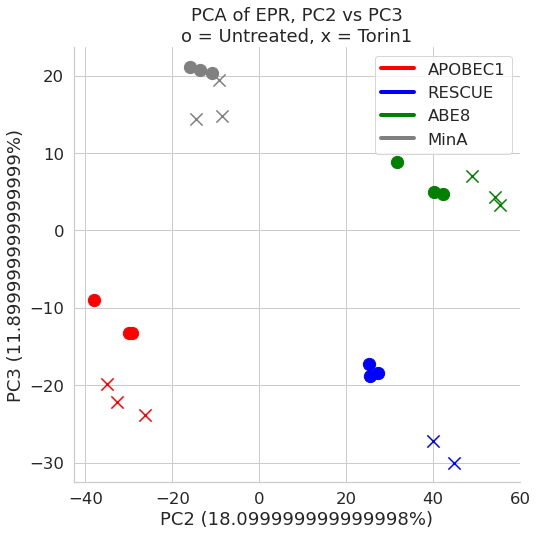

In [79]:
from matplotlib.lines import Line2D
shape_map = {
    'Torin': 'x',
    'Untreated': 'o',
    'R1': 'x', 
    'R2': 'o',
    'R3': '.'
}

color_map = {
    'APOBEC1': 'red',
    'RESCUE': 'blue',
    'ABE8': 'green',
    'MinA': 'gray',
    #'APOBEC1_alone': '#550000',
    #'RESCUE_alone': '#000055',
    #'ABE8e_alone': '#005500',
    #'MinA_alone': 'black'
}

var_explained = pd.DataFrame(pca.explained_variance_ratio_, pcs)

    
custom_lines = []
legend = []
for enzyme, color in color_map.items():
    custom_lines.append(Line2D([0], [0], color=color, lw=4))
    legend.append(enzyme)


pc_comps = [['PC1', 'PC2'], ['PC2', 'PC3']]
for pc_comp in pc_comps:
    plt.figure(figsize=(8, 8))
    for r in principalDf.iterrows():
        
        pc_x = r[1][pc_comp[0]]
        pc_y = r[1][pc_comp[1]]

        label = r[0]
        
        if 'alone' in label:
            continue
        for key, value in color_map.items():
            if key in label:
                color = value
                continue


            
        if 'Torin' in label:
            shape = shape_map.get('Torin')
        else:
            shape = shape_map.get('Untreated')

        """
        if 'R1' in label:
            shape = shape_map.get('R1')
        elif 'R2' in label:
            shape = shape_map.get('R2')
        elif 'R3' in label:
            shape = shape_map.get('R3')
        """ 
        plt.scatter(pc_x, pc_y, color=color, marker=shape, s=150)

    x_var = round(float(var_explained.loc[pc_comp[0]]), 3) * 100
    y_var = round(float(var_explained.loc[pc_comp[1]]), 3) * 100

    plt.xlabel('{} ({}%)'.format(pc_comp[0], x_var))
    plt.ylabel('{} ({}%)'.format(pc_comp[1], y_var))
    plt.title("PCA of EPR, {} vs {}\no = Untreated, x = Torin1".format(pc_comp[0], 
                                                                                                 pc_comp[1]
                                                                                                                  ))
    plt.legend(custom_lines, legend)

# Look at gene lists

In [1322]:
from collections import defaultdict

gene_lists_ct = defaultdict(lambda:[])
for k in comparisons_ct.keys():
    print(k)
    for g in sorted(list(metric_df_ct[(metric_df_ct['{}_pvalue'.format(k)] < 0.05) & (metric_df_ct['{}_stat'.format(k)] > 0)].index.dropna())):
        gene_lists_ct[k].append(g)
    

APOBEC1_alone
RPS2-APOBEC1


In [1323]:
gene_lists_ai = defaultdict(lambda:[])
for k in comparisons_ai.keys():
    print(k)
    for g in sorted(list(metric_df_ai[(metric_df_ai['{}_pvalue'.format(k)] < 0.05) & (metric_df_ai['{}_stat'.format(k)] > 0)].index.dropna())):
        gene_lists_ai[k].append(g)

ABE8e_alone
MinA_alone
RPS2-ABE83
RPS2-MinA


In [1296]:
print('CT')
for k, v in gene_lists_ct.items():
    print(k, len(v))

print('\nAI')
for k, v in gene_lists_ai.items():
    print(k, len(v))

CT
APOBEC1_alone 60
RPS2-APOBEC1 118

AI
ABE8e_alone 17
MinA_alone 70
RPS2-ABE83 38
RPS2-MinA 39


In [1297]:
apo_genes = []
for g in gene_lists_ct.get('RPS2-APOBEC1'):
    apo_genes.append(g)
    
apo_alone_genes = []
for g in gene_lists_ct.get('APOBEC1_alone'):
    apo_alone_genes.append(g)
    

### overlap among reduced genes

# Bar plots

In [1301]:
ratio_dfs = {}

In [1331]:

label = 'all_genes'
#label = 'TOP_genes'

def clause_all(i): 
    return True

def clause_top(i): 
    return i in top_genes_list

label_to_clause = {
    'all_genes': clause_all,
    'TOP_genes': clause_top 
}

clause = label_to_clause.get(label)

top_genes_ct = [i for i in list(metric_df_ct.index) if type(i) == str and clause(i)]
top_genes_ai = [i for i in list(metric_df_ai.index) if type(i) == str and clause(i)]
top_genes_78 = [i for i in list(metric_df_78.index) if type(i) == str and clause(i)]
top_genes_ct_stranded = [i for i in list(metric_df_ct_stranded.index) if type(i) == str and clause(i)]
top_genes_ai_stranded = [i for i in list(metric_df_ai_stranded.index) if type(i) == str and clause(i)]

len(top_genes_ct), len(top_genes_ai), len(top_genes_ct_stranded), len(top_genes_ai_stranded)

(4285, 4231, 4400, 4254)

### Established that proper config is (Reverse stranded true read 1, Reverse stranded false read 2)


<AxesSubplot:>

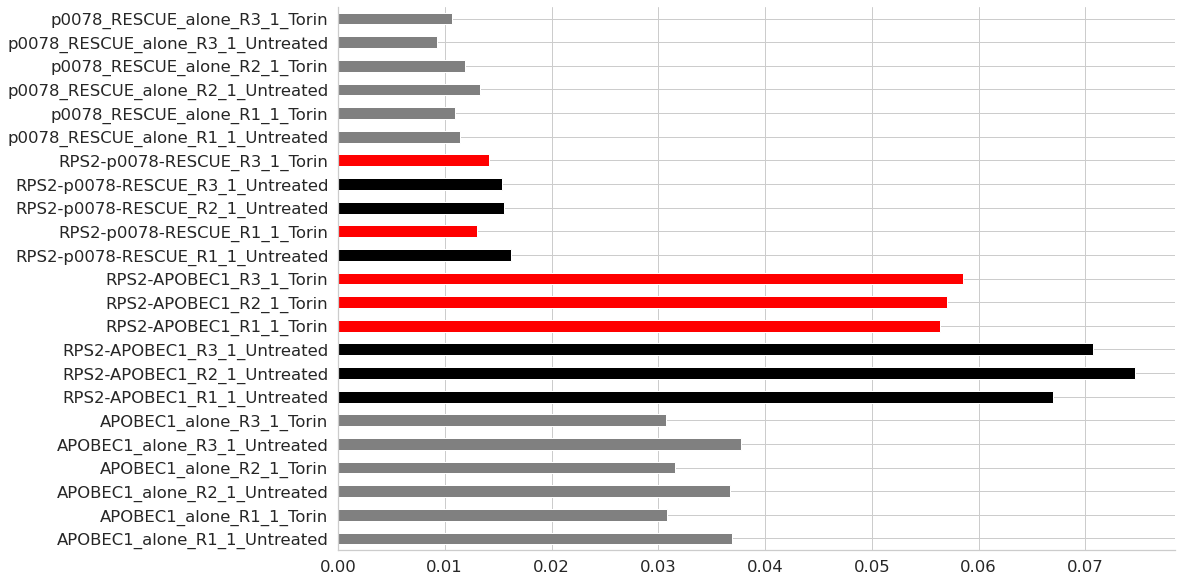

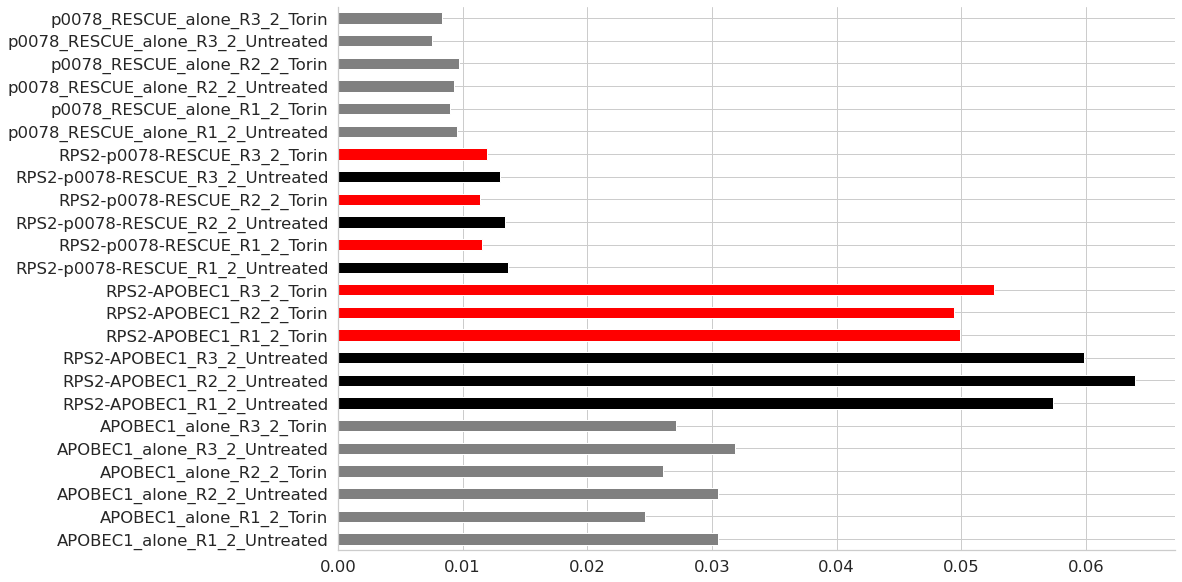

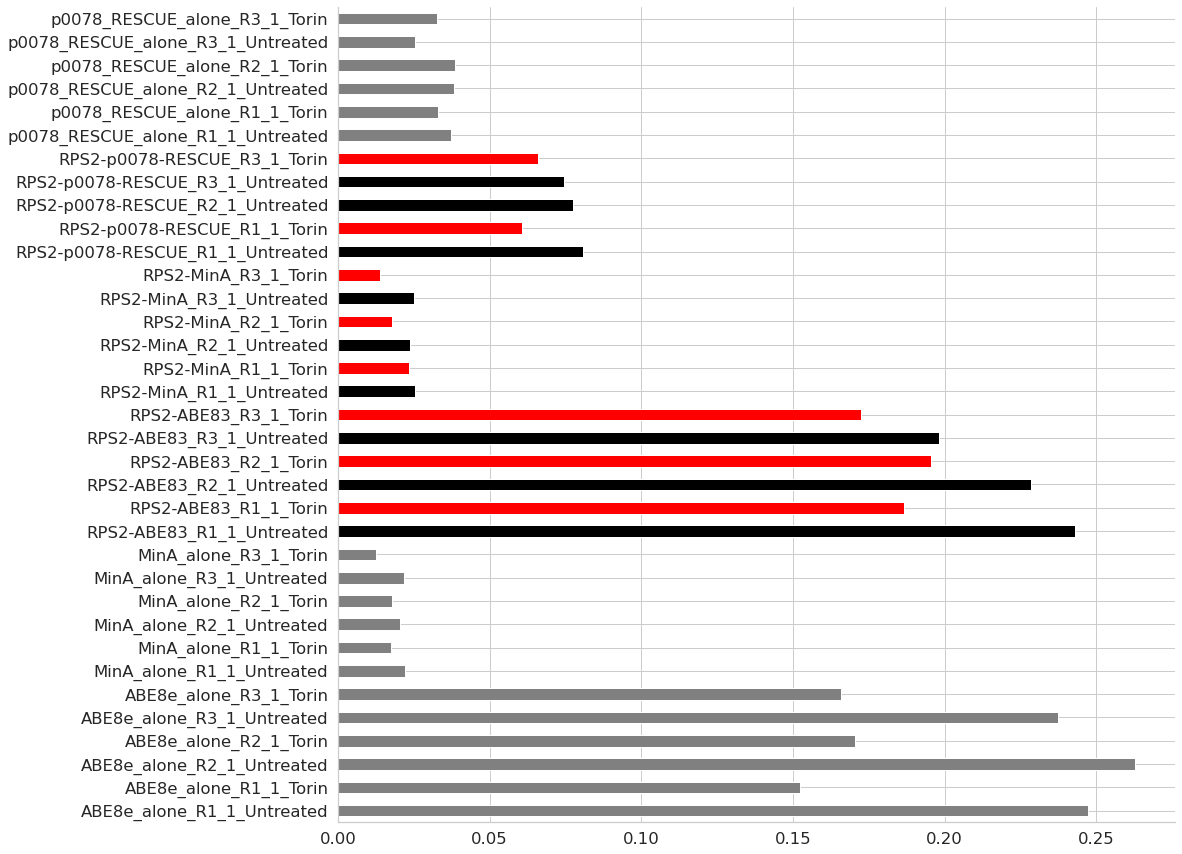

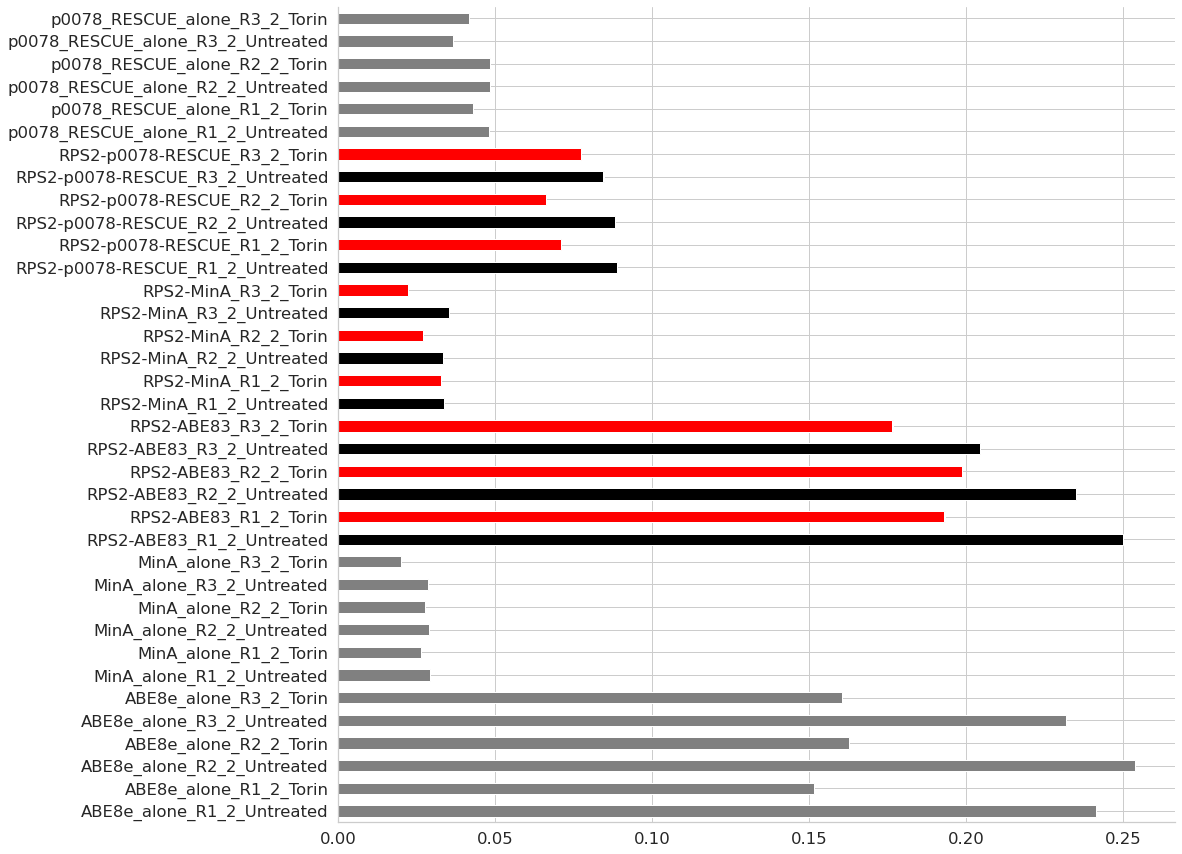

In [1332]:
from matplotlib import pyplot as plt

def get_color_from_name(name):
    if 'alone' in name:
        return 'gray'
     
    if 'Torin' in name:
        return 'red'
    else:
        return 'black'
    

plt.figure(figsize=(15, 10))
metric_df_ct_f = metric_df_ct[[c for c in metric_df_ct.columns if '_1_' in c]]
metric_df_ct_f[[c for c in metric_df_ct_f.columns if 'stat' not in c  and 'pvalue' not in c]].loc[top_genes_ct].mean().plot(kind='barh', color=[get_color_from_name(i) for i in metric_df_ct_f.columns])
#plt.savefig('images/CT_Torin.svg', bbox_inches='tight')

plt.figure(figsize=(15, 10))
metric_df_ct_stranded_f = metric_df_ct_stranded[[c for c in metric_df_ct_stranded.columns if '_2_' in c]]
metric_df_ct_stranded_f.loc[top_genes_ct_stranded].mean().plot(kind='barh', color=[get_color_from_name(i) for i in metric_df_ct_stranded_f.columns])

plt.figure(figsize=(15, 15))
# true
metric_df_ai_f = metric_df_ai[[c for c in metric_df_ai.columns if '_1_' in c]]
metric_df_ai_f.loc[top_genes_ai].mean().plot(kind='barh', color=[get_color_from_name(i) for i in metric_df_ai_f.columns])
#plt.savefig('images/AI_Torin.svg', bbox_inches='tight')

plt.figure(figsize=(15, 15))
# false
metric_df_ai_stranded_f = metric_df_ai_stranded[[c for c in metric_df_ai_stranded.columns if '_2_' in c]]
metric_df_ai_stranded_f.loc[top_genes_ai_stranded].mean().plot(kind='barh', color=[get_color_from_name(i) for i in metric_df_ai_stranded_f.columns])
metric_df_ai_stranded_f.mean().plot(kind='barh', color=[get_color_from_name(i) for i in metric_df_ai_stranded_f.columns])

<AxesSubplot:>

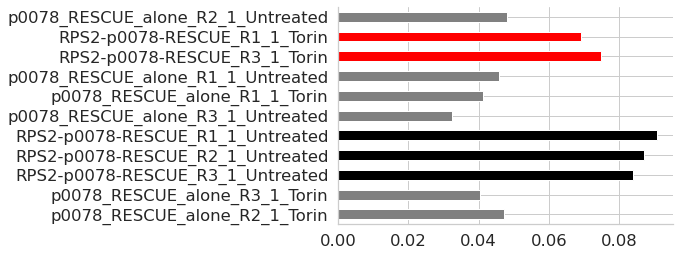

In [1333]:
metric_df_78_f = metric_df_78[[c for c in metric_df_78.columns if '_1_' in c]]
metric_df_78_f.loc[top_genes_78].mean().plot(kind='barh', color=[get_color_from_name(i) for i in metric_df_78_f.columns])

# Boxplots, grouping replicates

In [1347]:
from matplotlib import pyplot as plt
from collections import defaultdict
import numpy as np


def box_vals_from_metrics_df(metric_df, exclude=[]):
    data_by_category = defaultdict(lambda:[])

    for c in metric_df.columns:
        #if 'alone' in c:
        #    continue

        if 'R2' in c:
            category = c.split("_R2")[0]
        elif 'R1' in c:
            category = c.split("_R1")[0]
        elif 'R3' in c:
            category = c.split("_R3")[0]
            
        if category.endswith('APOBE'):
            category = category.replace("APOBE", "APOBEC1")
        
        condition = c.split("_")[-1]
        
        if category in exclude:
            print("\tIgnoring {}".format(category))
            continue

        if condition == 'Untreated':
            condition = '-torin1'
        elif condition == 'Torin':
            condition = '+torin1'
            
        overall_category = '{} ({})'.format(category.replace('_', ' '), condition)
        print(category, condition, overall_category)

        data_by_category[overall_category].append(np.mean(metric_df[c].to_list()))

    list_of_keys = list(data_by_category.keys())
    list_of_lists = [data_by_category.get(k) for k in list_of_keys]
    
    return data_by_category, list_of_keys, list_of_lists


In [1349]:
metric_df_ai_f

,ABE8e_alone_R1_1_Untreated,ABE8e_alone_R1_1_Torin,ABE8e_alone_R2_1_Untreated,ABE8e_alone_R2_1_Torin,ABE8e_alone_R3_1_Untreated,ABE8e_alone_R3_1_Torin,MinA_alone_R1_1_Untreated,MinA_alone_R1_1_Torin,MinA_alone_R2_1_Untreated,MinA_alone_R2_1_Torin,...,RPS2-p0078-RESCUE_R1_1_Torin,RPS2-p0078-RESCUE_R2_1_Untreated,RPS2-p0078-RESCUE_R3_1_Untreated,RPS2-p0078-RESCUE_R3_1_Torin,p0078_RESCUE_alone_R1_1_Untreated,p0078_RESCUE_alone_R1_1_Torin,p0078_RESCUE_alone_R2_1_Untreated,p0078_RESCUE_alone_R2_1_Torin,p0078_RESCUE_alone_R3_1_Untreated,p0078_RESCUE_alone_R3_1_Torin
Gene name,,,,,,,,,,,,,,,,,,,,,
LINC02593,0.004682,0.006144,0.015743,0.013540,0.015209,0.007290,0.006656,0.001567,0.002722,0.003026,...,0.005674,0.011511,0.011179,0.006720,0.004476,0.005510,0.010757,0.005674,0.005376,0.015957
SAMD11,0.034674,0.041176,0.036459,0.049168,0.027230,0.037632,0.006619,0.007698,0.006716,0.005913,...,0.063492,0.069441,0.057651,0.052055,0.016856,0.021407,0.024269,0.022642,0.021382,0.027266
NOC2L,0.114358,0.055758,0.141685,0.073145,0.149960,0.067673,0.003305,0.004665,0.005841,0.004138,...,0.054614,0.074669,0.071141,0.063562,0.023828,0.023904,0.027901,0.031659,0.014645,0.025580
HES4,0.011031,0.008855,0.013149,0.015532,0.009110,0.021734,0.002327,0.004898,0.002076,0.002014,...,0.058673,0.049111,0.027509,0.043818,0.017178,0.017085,0.014304,0.019577,0.009504,0.019946
ACAP3,0.088574,0.040703,0.120391,0.041142,0.080895,0.052174,0.007843,0.006285,0.002299,0.003796,...,0.048059,0.065998,0.057377,0.033573,0.019874,0.024276,0.015758,0.018587,0.011132,0.008071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND4L,0.000000,0.000530,0.001149,0.000355,0.002006,0.002064,0.000125,0.000227,0.001384,0.000036,...,0.001125,0.000637,0.000761,0.001386,0.000378,0.000824,0.000488,0.000754,0.000244,0.001670
MT-ND4,0.062736,0.070092,0.061642,0.064401,0.065008,0.062337,0.065630,0.061568,0.065305,0.062773,...,0.068574,0.064810,0.069808,0.060052,0.061092,0.066328,0.061282,0.061959,0.058208,0.063145
MT-ND5,0.004546,0.004708,0.005302,0.003697,0.005358,0.006050,0.003831,0.004879,0.003618,0.004571,...,0.004049,0.005393,0.005116,0.004390,0.004026,0.006305,0.004435,0.004294,0.003927,0.006145


In [1356]:
print("\nCT\n")
data_by_category_ct, list_of_keys_ct, list_of_lists_ct = box_vals_from_metrics_df(metric_df_ct_f[[c for c in metric_df_ct_f.columns if 'alone' not in c and '78' not in c]].loc[top_genes_ct])#, exclude=['RPS2-p0078-RESCUE'])

print("\nAI\n")
data_by_category_ai, list_of_keys_ai, list_of_lists_ai = box_vals_from_metrics_df(metric_df_ai_f[[c for c in metric_df_ai_f.columns if 'alone' not in c and '78' not in c]].loc[top_genes_ai])

print("\n78")
data_by_category_78, list_of_keys_78, list_of_lists_78 = box_vals_from_metrics_df(metric_df_78_f[[c for c in metric_df_78_f.columns if 'alone' not in c]].loc[top_genes_78])


CT

RPS2-APOBEC1 -torin1 RPS2-APOBEC1 (-torin1)
RPS2-APOBEC1 -torin1 RPS2-APOBEC1 (-torin1)
RPS2-APOBEC1 -torin1 RPS2-APOBEC1 (-torin1)
RPS2-APOBEC1 +torin1 RPS2-APOBEC1 (+torin1)
RPS2-APOBEC1 +torin1 RPS2-APOBEC1 (+torin1)
RPS2-APOBEC1 +torin1 RPS2-APOBEC1 (+torin1)

AI

RPS2-ABE83 -torin1 RPS2-ABE83 (-torin1)
RPS2-ABE83 +torin1 RPS2-ABE83 (+torin1)
RPS2-ABE83 -torin1 RPS2-ABE83 (-torin1)
RPS2-ABE83 +torin1 RPS2-ABE83 (+torin1)
RPS2-ABE83 -torin1 RPS2-ABE83 (-torin1)
RPS2-ABE83 +torin1 RPS2-ABE83 (+torin1)
RPS2-MinA -torin1 RPS2-MinA (-torin1)
RPS2-MinA +torin1 RPS2-MinA (+torin1)
RPS2-MinA -torin1 RPS2-MinA (-torin1)
RPS2-MinA +torin1 RPS2-MinA (+torin1)
RPS2-MinA -torin1 RPS2-MinA (-torin1)
RPS2-MinA +torin1 RPS2-MinA (+torin1)

78
RPS2-p0078-RESCUE -torin1 RPS2-p0078-RESCUE (-torin1)
RPS2-p0078-RESCUE -torin1 RPS2-p0078-RESCUE (-torin1)
RPS2-p0078-RESCUE -torin1 RPS2-p0078-RESCUE (-torin1)
RPS2-p0078-RESCUE +torin1 RPS2-p0078-RESCUE (+torin1)
RPS2-p0078-RESCUE +torin1 RPS2-p0078-R

In [1357]:
list_of_combined_keys = [i for i in reversed(list_of_keys_ct + list_of_keys_ai + list_of_keys_78)]
list_of_combined_lists = [i for i in reversed(list_of_lists_ct + list_of_lists_ai + list_of_lists_78)]

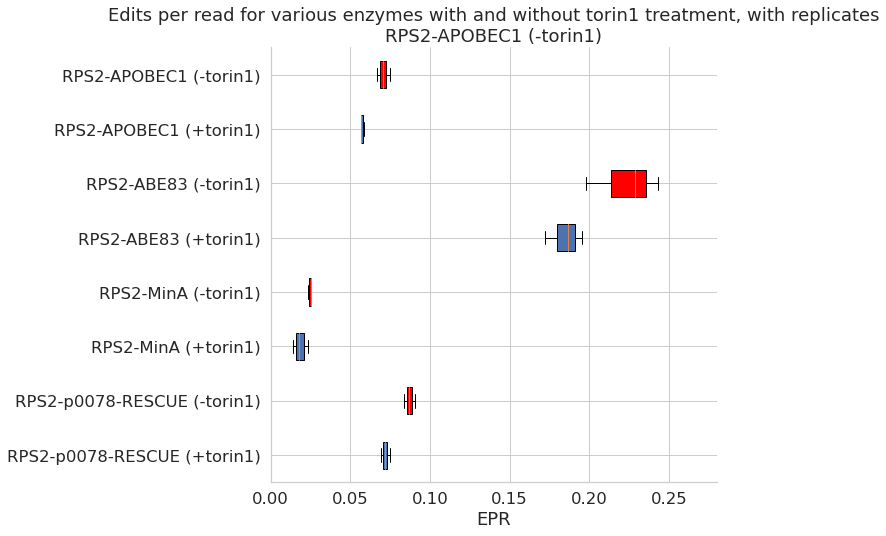

In [1363]:
import seaborn as sns
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)

plt.figure(figsize=(8, 8))

a = plt.boxplot(list_of_combined_lists, vert=False, patch_artist=True)
for patch, label in zip(a['boxes'], list_of_combined_keys):
    if '-torin' in label:
        patch.set_facecolor('red')
        
range_array= [i+1 for i in range(len(list_of_combined_keys))]
b = plt.yticks(range_array, list_of_combined_keys)
plt.xlabel(metric.upper())
plt.xlim(0, 0.28)
plt.title("Edits per read for various enzymes with and without torin1 treatment, with replicates\n{}".format(label.replace("_", " ")))
plt.savefig("images/EPR_with_without_torin1_with_replicates_boxplot_{}_with_alone.svg".format(label), bbox_inches='tight')

In [71]:
set_of_combined_keys = set()

for k in list_of_combined_keys:
    set_of_combined_keys.add(k.split(' (')[0])
    
set_of_combined_keys = list(set_of_combined_keys)

In [72]:
torin_reduction_by_enzyme = {}

for enzyme in set_of_combined_keys:
    print(enzyme)
    
    try:
        torin_mean = np.mean(data_by_category_ct.get('{} (+torin1)'.format(enzyme)))
        control_mean = np.mean(data_by_category_ct.get('{} (-torin1)'.format(enzyme)))
    except Exception as e:
        torin_mean = np.mean(data_by_category_ai.get('{} (+torin1)'.format(enzyme)))
        control_mean = np.mean(data_by_category_ai.get('{} (-torin1)'.format(enzyme)))
        
    torin_reduction = torin_mean/control_mean
    torin_reduction_by_enzyme[enzyme] = torin_reduction

RPS2-ABE83
p0078 RESCUE alone
ABE8e alone
APOBEC1 alone
MinA alone
RPS2-MinA
RPS2-p0078-RESCUE
RPS2-APOBEC1


In [73]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", rc=custom_params, font_scale=1.5)
ratio_df = pd.DataFrame.from_dict(torin_reduction_by_enzyme, orient='index', columns=['EPR reduction'])
#ratio_df = ratio_df.loc[reversed(['RPS2-APOBEC1', 'RPS2-ABE83', 'RPS2-MinA', 'RPS2-p0078-RESCUE'])]

ratio_df = ratio_df.loc[reversed(['RPS2-APOBEC1', 'APOBEC1 alone', 'RPS2-ABE83', 'ABE8e alone', 'RPS2-MinA', 'MinA alone', 'RPS2-p0078-RESCUE', 'p0078 RESCUE alone'])]

In [74]:


ratio_dfs[label] = ratio_df

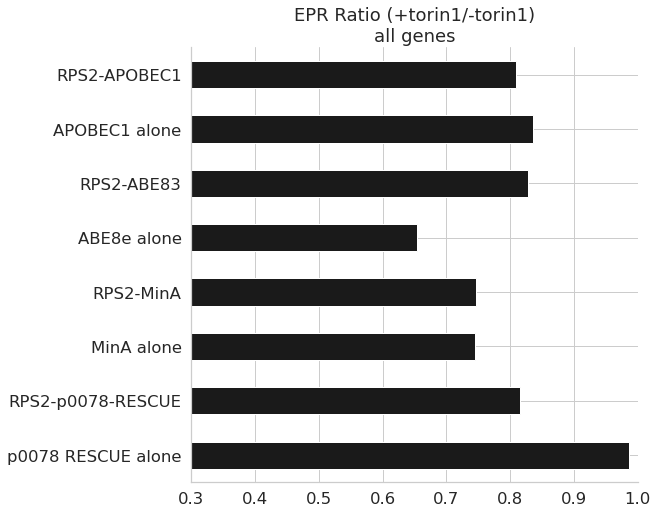

In [75]:
ratio_df.plot(kind='barh', legend=False, color='k', figsize=(8, 8))
plt.xlim(0.3, 1)
plt.title("EPR Ratio (+torin1/-torin1)\n{}".format(label.replace("_", " ")))
plt.savefig("images/EPR_with_without_torin1_with_ratio_barplot_{}_with_alone.svg".format(label), bbox_inches='tight')

# Gene-level

In [78]:
concatted = pd.concat([ratio_dfs.get('all_genes'), ratio_dfs.get('TOP_genes')], axis=1)
concatted.columns = ['all_genes_reduction', 'TOP_genes_reduction']

In [79]:
concatted

,all_genes_reduction,TOP_genes_reduction
p0078 RESCUE alone,0.986325,0.828526
RPS2-p0078-RESCUE,0.816118,0.464841
MinA alone,0.745019,0.423482
RPS2-MinA,0.746683,0.515378
ABE8e alone,0.653848,0.484342
RPS2-ABE83,0.827627,0.669194
APOBEC1 alone,0.835956,0.537487
RPS2-APOBEC1,0.809959,0.514002


In [80]:
concatted['all_genes_reduction'] / concatted['TOP_genes_reduction']

p0078 RESCUE alone    1.190458
RPS2-p0078-RESCUE     1.755693
MinA alone            1.759270
RPS2-MinA             1.448807
ABE8e alone           1.349971
RPS2-ABE83            1.236751
APOBEC1 alone         1.555307
RPS2-APOBEC1          1.575789
dtype: float64